In [1]:
#Evaluate the depth and area averaged temp timeseries in JRA-55 ACCESS=OM2-01-IAF runs

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath


import scipy as sp
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame

import statsmodels.api as sm

import xesmf as xe

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:35671 Dashboard: http://127.0.0.1:38929/status,Cluster Workers: 4 Cores: 4 Memory: 5.62 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

In [4]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [5]:
expt='01deg_jra55v140_iaf'
variable='ht'
ht = cc.querying.getvar('01deg_jra55v140_iaf','ht',session,n=1).sel(yt_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
ht.load()
print(ht.shape)

expt='01deg_jra55v140_iaf'
variable='hu'
hu = cc.querying.getvar('01deg_jra55v140_iaf','hu',session,n=1).sel(yu_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
hu.load()
print(hu.shape)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed backends via the ``engine`` parameter to xarray.open_dataset(), or installing additional IO dependencies:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [26]:
variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
xt_ocean.load()
print(xt_ocean.values)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
area_t.load()
print(area_t.shape)

[-280 -280 -280 ...   78   78   78]
(2700,)
(2700, 3600)


In [27]:
#do maskito_netcdfepths = (0,300)
#htmask = temp.where(~xr.ufuncs.isfinite(temp.where(ht>1000)))
#htmask = ~xr.ufuncs.isnan(htmask).to_dataset(name='htmask')
#htmask

#var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True

tmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
tmask = tmask.where(~xr.ufuncs.isfinite(tmask.where(yt_ocean>-60)))
tmask = ~xr.ufuncs.isnan(tmask).to_dataset(name='tmask')

#wap_mask = ht.where(~xr.ufuncs.isfinite(ht.where( (ht>1000) & (yt_ocean>-60) & (xt_ocean<-75) & (xt_ocean>-63) )))
wap_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
wap_mask = wap_mask.where(~xr.ufuncs.isfinite(wap_mask.where(yt_ocean>-60)))
wap_mask=wap_mask.where(~xr.ufuncs.isfinite(wap_mask.where(xt_ocean<-75)))
wap_mask=wap_mask.where(~xr.ufuncs.isfinite(wap_mask.where(xt_ocean>-63)))
wap_mask = ~xr.ufuncs.isnan(wap_mask).to_dataset(name='wap_mask')

#bs_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-101) & (xt_ocean>-76) )))
bs_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
bs_mask = bs_mask.where(~xr.ufuncs.isfinite(bs_mask.where(yt_ocean>-60)))
bs_mask=bs_mask.where(~xr.ufuncs.isfinite(bs_mask.where(xt_ocean<-101)))
bs_mask=bs_mask.where(~xr.ufuncs.isfinite(bs_mask.where(xt_ocean>-76)))
bs_mask = ~xr.ufuncs.isnan(bs_mask).to_dataset(name='bs_mask')

#as_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-127) & (xt_ocean>-102) )))
as_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
as_mask = as_mask.where(~xr.ufuncs.isfinite(as_mask.where(yt_ocean>-60)))
as_mask=as_mask.where(~xr.ufuncs.isfinite(as_mask.where(xt_ocean<-127)))
as_mask=as_mask.where(~xr.ufuncs.isfinite(as_mask.where(xt_ocean>-102)))
as_mask = ~xr.ufuncs.isnan(as_mask).to_dataset(name='as_mask')

#revised area of AS ice shelves based on Fig. 4e inset of Admusilli https://doi.org/10.1038/s41561-020-0616-z
#as_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-127) & (xt_ocean>-102) )))
as_mask2 = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
as_mask2 = as_mask2.where(~xr.ufuncs.isfinite(as_mask2.where(yt_ocean>-60)))
as_mask2=as_mask2.where(~xr.ufuncs.isfinite(as_mask2.where(xt_ocean<-137)))
as_mask2=as_mask2.where(~xr.ufuncs.isfinite(as_mask2.where(xt_ocean>-102)))
as_mask2 = ~xr.ufuncs.isnan(as_mask2).to_dataset(name='as_mask2')

#mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where((ht>1000) & (yt_ocean>-60) & (xt_ocean<-158) & (xt_ocean>-103) )))
mb_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
mb_mask = mb_mask.where(~xr.ufuncs.isfinite(mb_mask.where(yt_ocean>-60)))
mb_mask=mb_mask.where(~xr.ufuncs.isfinite(mb_mask.where(xt_ocean<-158)))
mb_mask=mb_mask.where(~xr.ufuncs.isfinite(mb_mask.where(xt_ocean>-103)))
mb_mask = ~xr.ufuncs.isnan(mb_mask).to_dataset(name='mb_mask')

mb_mask

<xarray.Dataset>
Dimensions:   (xt_ocean: 3600, yt_ocean: 584)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
Data variables:
    mb_mask   (yt_ocean, xt_ocean) bool False False False ... False False False

#get long-term average
expt='025deg_jra55_iaf_omip2_cycle3'
start = '1971-01-01 00:00:00'
end = '2017-12-31 00:00:00'
ltm_temp = cc.querying.getvar(expt, variable='temp', 
                       session=session, frequency='1 monthly',
                       start_time=start, 
                       end_time=end).sel(time=slice(start,end)).mean(dim='time').chunk({'st_ocean':25, 'yt_ocean':540, 'xt_ocean':720})
#temp.load()
ltm_temp.load()
ltm_temp.shape

ltm_temp.to_dataset(name='ltm_temp').to_netcdf('ltm_temp_025_cycle3.nc')

In [28]:
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

In [29]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [30]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries ...???
    ## Calculates effective sample size using lag1-autocorrelations (Kial Stewart)
    ## Also, finds sampe size by a second method thanks to Josue
    
    n = len(y1)
    nc = int(n/3.5) #end effects? I don't understand this line.
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = scipy.stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = scipy.stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = scipy.stats.pearsonr(x1t, x2t)
    
    #Josue's alternate Neff method
    idx = np.arange(1,nc)
    sni = np.sum((1 - idx/nc) * cor[idx])
    n_star = 1 + 2 * sni
    Neff2 = n/n_star

    return cor, sig, Neff, Neff2

In [31]:
yrs=np.arange(1958.5,2019.5,1)

(1788, 1)
1055
(1980, 1)
1247
here (60, 1) (60, 1)
[1958.] [1958.] 1958
(733, 1) (60,)
(60, 1) (60, 1)


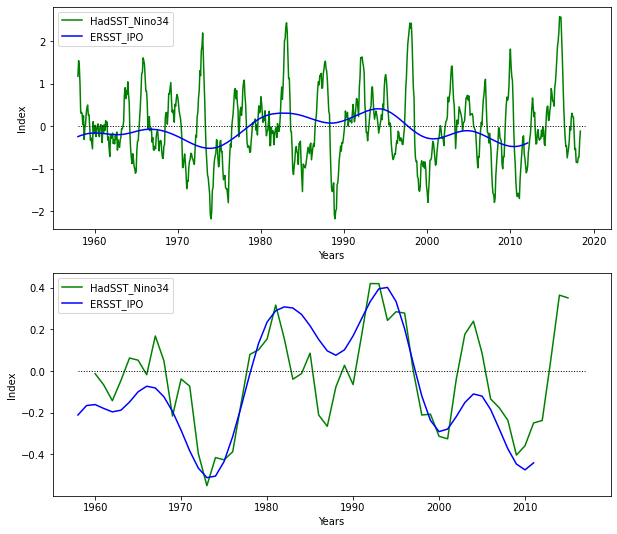

In [32]:
#n34yr = year
#n34mn = month
#n34yrd = year + month/12
#it's 1870-2018
hadsst = sp.io.loadmat('/home/561/pas561/gdv45/jnb/ensoant/data/HadISST_Nino3p4.mat')#,'bat_lat')
hadsst_n34yr=hadsst['n34yr']
hadsst_n34yrd=hadsst['n34yrd']
hadsst_n34=hadsst['n34']
print(hadsst_n34yrd.shape)
hadsst_yri = np.nonzero(hadsst_n34yrd == 1958)[0][0]
print(hadsst_yri)

#print ERSST_ipo[ERSST_yri:ERSST_yri+12]
hadsst_n34_ann=np.zeros((60,1))
i=hadsst_yri
for t in range(60):
        #print hadsst_yri
        hadsst_n34_ann[t]=np.mean(hadsst_n34[i:i+12])
        i=i+12


#ipo = time series
#ipoyr = year
#ipomn = month
#ipoyrd = year + month/12 (edited)
ERSST= sp.io.loadmat('/home/561/pas561/gdv45/jnb/ensoant/data/TPI_ERSSTV5_IPOindex.mat')
ERSST_ipo=ERSST['ipo']
ERSST_ipoyrd=ERSST['ipoyrd']
ERSST_ipoyr=ERSST['ipoyr']
print(ERSST_ipo.shape)
ERSST_yri = np.nonzero(ERSST_ipoyrd == 1958)[0][0]
print(ERSST_yri)

#print ERSST_ipo[ERSST_yri:ERSST_yri+12]
ERSST_ipo_ann=np.zeros((60,1))
i=ERSST_yri
for t in range(60):
        #print ERSST_yri
        ERSST_ipo_ann[t]=np.mean(ERSST_ipo[i:i+12])
        i=i+12



fig = plt.figure(figsize=(10, 9))

plt.subplot(211)
plt.plot(hadsst_n34yrd[hadsst_yri:],hadsst_n34[hadsst_yri:],linestyle='-',color='g',label='HadSST_Nino34',linewidth=1.5)
plt.plot(ERSST_ipoyrd[ERSST_yri:],ERSST_ipo[ERSST_yri:],linestyle='-',color='b',label='ERSST_IPO',linewidth=1.5)
plt.plot(ERSST_ipoyrd[ERSST_yri:],np.zeros((ERSST_ipoyrd[ERSST_yri:].shape)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Index')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('Nino34')
plt.legend(fontsize=10)


yrs=np.arange(1958,2018,1)
print('here', hadsst_n34_ann.shape, ERSST_ipo_ann.shape)
print(hadsst_n34yrd[hadsst_yri], ERSST_ipoyrd[ERSST_yri], yrs[0])
print(hadsst_n34yrd[hadsst_yri:].shape, yrs.shape)

df= pd.DataFrame(hadsst_n34_ann)
hadsst_n34_ann_5yr = df.rolling(window=5, center=True).mean().values
print(hadsst_n34_ann.shape,hadsst_n34_ann_5yr.shape)

plt.subplot(212)
plt.plot(yrs[0:],hadsst_n34_ann_5yr,linestyle='-',color='g',label='HadSST_Nino34',linewidth=1.5)
plt.plot(yrs[0:],ERSST_ipo_ann,linestyle='-',color='b',label='ERSST_IPO',linewidth=1.5)
plt.plot(yrs[0:],np.zeros((60,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((1037.5,1035))
plt.ylabel('Index')
plt.xlabel('Years')
#plt.xlim([-75,85])
#plt.title('Nino34')
plt.legend(fontsize=10)


In [33]:
as_mr = np.genfromtxt ('/g/data/v45/pas561/jnb/ensoant/data/melt_rate_amundsen.csv', delimiter=",")
print(as_mr.shape,as_mr[:,0])
print(yrs[36],yrs[36:].shape)

#calculate annual means from seasonal data (DJF,MAM,JJA,SON)

as_mr_yr=as_mr[1:,:].reshape(25,4,3)
print(as_mr_yr.shape)
as_mr_yr=np.mean(as_mr_yr,axis=1)
print(as_mr_yr.shape,as_mr_yr[:,0])

#as_mr_yr[:,0]=np.arange(1994,2019,1)
#print(as_mr_yr[:,0])


(101, 3) [    nan 1994.16 1994.41 1994.66 1994.91 1995.16 1995.41 1995.66 1995.91
 1996.16 1996.41 1996.66 1996.91 1997.16 1997.41 1997.66 1997.91 1998.16
 1998.41 1998.66 1998.91 1999.16 1999.41 1999.66 1999.91 2000.16 2000.41
 2000.66 2000.91 2001.16 2001.41 2001.66 2001.91 2002.16 2002.41 2002.66
 2002.91 2003.16 2003.41 2003.66 2003.91 2004.16 2004.41 2004.66 2004.91
 2005.16 2005.41 2005.66 2005.91 2006.16 2006.41 2006.66 2006.91 2007.16
 2007.41 2007.66 2007.91 2008.16 2008.41 2008.66 2008.91 2009.16 2009.41
 2009.66 2009.91 2010.16 2010.41 2010.66 2010.91 2011.16 2011.41 2011.66
 2011.91 2012.16 2012.41 2012.66 2012.91 2013.16 2013.41 2013.66 2013.91
 2014.16 2014.41 2014.66 2014.91 2015.16 2015.41 2015.66 2015.91 2016.16
 2016.41 2016.66 2016.91 2017.16 2017.41 2017.66 2017.91 2018.16 2018.41
 2018.66 2018.91]
1994 (24,)
(25, 4, 3)
(25, 3) [1994.535 1995.535 1996.535 1997.535 1998.535 1999.535 2000.535 2001.535
 2002.535 2003.535 2004.535 2005.535 2006.535 2007.535 2008.535 200

No handles with labels found to put in legend.


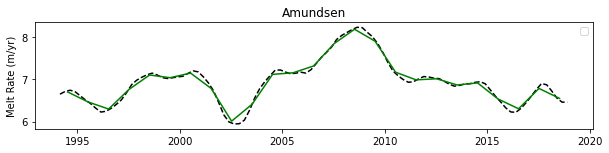

In [34]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty

fig = plt.figure(figsize=(10, 9))

ax1=plt.subplot(411)
ax1.plot(as_mr[1:,0],as_mr[1:,1],linestyle='--',color='k',linewidth=1.5)
ax1.plot(as_mr_yr[:,0],as_mr_yr[:,1],linestyle='-',color='g',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Melt Rate (m/yr)',color='k')
#ax1.tick_params('y', colors='b')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

In [35]:
#this Amundsen Sea masks doesn't go far enough west relative to Admusilli map ... redo masking
#load the annual mean temp data
#starts in 1958
#as_t=np.load('/g/data/v45/pas561/jnb/ensoant/025_cyc2to5_200to500_temp_as_ts.npy')
as_t_200to500=np.load('ensoant/data/as_temp_01_cycle2to3_200to500_5801to1812.npy')
print(as_t_200to500.shape)

as_t_300to700=np.load('ensoant/data/as_temp_01_cycle2to3_300to700_5801to1812.npy')
print(as_t_300to700.shape)

as_t_200to1000=np.load('ensoant/data/as_temp_01_cycle2to3_200to1000_5801to1812.npy')
print(as_t_200to1000.shape)


(2, 61)
(2, 61)
(2, 61)


as_t_200to1000-as_t_200to500

In [36]:
#Redo spatial averaging using Admusilli AS mask area (more area to the west)
f=xr.open_dataset('ensoant/data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
t1=f.t_zavg.where(as_mask2.as_mask2).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t1.shape)

f=xr.open_dataset('ensoant/data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
t2=f.t_zavg.where(as_mask2.as_mask2).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t2.shape)

t=xr.concat([t1,t2],'cycle')
print(t.shape,t1.shape,t2.shape)

as_t_200to1000_v2=t.values
print(as_t_200to1000_v2,as_t_200to1000_v2.shape)

(61,)
(61,)
(2, 61) (61,) (61,)
[[273.67589613 273.70555264 273.73008381 273.5332275  273.51572083
  273.51398927 273.50488716 273.51983633 273.49032699 273.33858404
  273.2232043  273.13726268 272.89299192 272.65017593 272.50537518
  272.49374096 272.46880235 272.49553827 272.67456156 272.78470742
  272.86311901 272.9050156  273.04515981 273.15833171 273.22782845
  273.25217388 273.29410707 273.35118602 273.42999314 273.54098882
  273.54317772 273.50851791 273.47095883 273.46518017 273.53885194
  273.62167914 273.68599833 273.71572288 273.67872989 273.66112869
  273.69230625 273.60937901 273.55198291 273.58059437 273.68161931
  273.75898295 273.78537563 273.80781294 273.79481439 273.78012072
  273.70929655 273.62859906 273.61955262 273.52786821 273.49448517
  273.49343463 273.44494373 273.48046353 273.60968046 273.64705772
  273.65545023]
 [273.66024872 273.69965911 273.7299617  273.54456409 273.51914056
  273.51807347 273.48466608 273.47528176 273.41117062 273.24936318
  273.13148138

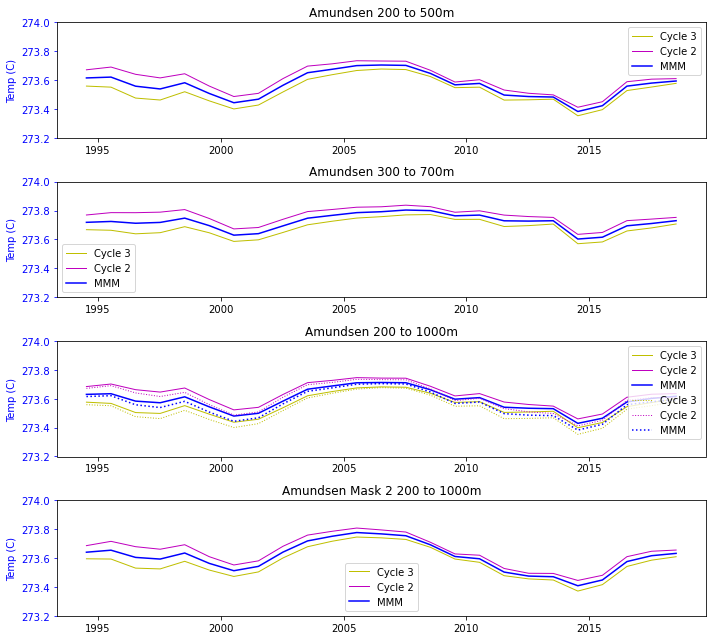

In [37]:
myr=36 #annual means start in 1958, seasonal in 59
yrs=np.arange(1958.5,2019.5,1)

fig = plt.figure(figsize=(10, 9))

ax1=plt.subplot(411)
ax1.plot(as_mr_yr[:,0],as_t_200to500[1,myr:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(as_mr_yr[:,0],as_t_200to500[0,myr:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(as_mr_yr[:,0],np.mean(as_t_200to500[:,myr:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MMM')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen 200 to 500m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(412)
ax1.plot(as_mr_yr[:,0],as_t_300to700[1,myr:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(as_mr_yr[:,0],as_t_300to700[0,myr:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(as_mr_yr[:,0],np.mean(as_t_300to700[:,myr:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MMM')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen 300 to 700m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(413)
ax1.plot(as_mr_yr[:,0],as_t_200to1000[1,myr:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(as_mr_yr[:,0],as_t_200to1000[0,myr:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(as_mr_yr[:,0],np.mean(as_t_200to1000[:,myr:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MMM')

ax1.plot(as_mr_yr[:,0],as_t_200to500[1,myr:],linestyle=':',color='y',linewidth=1,label='Cycle 3')
ax1.plot(as_mr_yr[:,0],as_t_200to500[0,myr:],linestyle=':',color='m',linewidth=1,label='Cycle 2')
ax1.plot(as_mr_yr[:,0],np.mean(as_t_200to500[:,myr:],axis=0),linestyle=':',color='b',linewidth=1.5,label='MMM')
ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen 200 to 1000m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(414)
ax1.plot(as_mr_yr[:,0],as_t_200to1000_v2[1,myr:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(as_mr_yr[:,0],as_t_200to1000_v2[0,myr:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(as_mr_yr[:,0],np.mean(as_t_200to1000_v2[:,myr:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MMM')
ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen Mask 2 200 to 1000m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

plt.tight_layout()

In [38]:
#annual correlation with temp stats - Amundsen Mask 1
maxlag=5
myr=36

#annual temp MMM: 1957-2018
#ts_t=np.mean(as_t[myr:,:],axis=1)
#l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
#print(ts_t.shape,l_t.shape)
#b=ts_t-l_t
b=np.mean(as_t_200to1000[:,myr:],axis=0)

#annual mean melrate
a=as_mr_yr[:,1]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
print(corstr)
corstr="%.0f:2017, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
print(corstr)

## Assumes b is leading
coef, signif, Neff, Neff2 = pearsoncor(b,a)
lag = coef.argmax() 
print('Correlations: %d years, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)

Tstat = coef*Neff**(0.5)*(1-coef**2)**(-0.5)
coef_sig = np.where(Tstat>2.0686,coef,np.NaN)
print(coef_sig) # looks good :)

#https://www.tutorialspoint.com/statistics/t_distribution_table.htm
#https://www.statisticshowto.com/t-statistic/
#n=23, twotails, for p=0.1, Tcrit=1.713 for  p0.05, Tcrit=2.0686

(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[2.94422954e-01 1.53107229e-01]
 [6.40134424e-01 7.54320981e-04]
 [7.87611519e-01 8.16892261e-06]
 [7.04676986e-01 2.50697149e-04]
 [5.25712620e-01 1.43797561e-02]
 [2.88284270e-01 2.17721500e-01]]
1994:2017, 2 yrs lag, R$^2$=0.62, R=0.79, P=0.00
1994:2017, 0 lag, R$^2$=0.09, R=0.29, P=0.15
Correlations: 2 years, 0.79, 0.00
Effective sample size: 7 or 5
T-statistic at max correlation: 3.45 
[       nan 0.64013442 0.78761152 0.70467699        nan        nan
        nan]


In [39]:
#annual correlation with temp stats -  - Amundsen Mask 2 ... more West
maxlag=5
myr=36

#annual temp MMM: 1957-2018
#ts_t=np.mean(as_t[myr:,:],axis=1)
#l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
#print(ts_t.shape,l_t.shape)
#b=ts_t-l_t
b=np.mean(as_t_200to1000_v2[:,myr:],axis=0)

#annual mean melrate
a=as_mr_yr[:,1]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
print(corstr)
corstr="%.0f:2017, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
print(corstr)

## Assumes b is leading
coef, signif, Neff, Neff2 = pearsoncor(b,a)
lag = coef.argmax() 
print('Correlations: %d years, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)

Tstat = coef*Neff**(0.5)*(1-coef**2)**(-0.5)
coef_sig = np.where(Tstat>2.0686,coef,np.NaN)
print(coef_sig) # looks good :)

#https://www.tutorialspoint.com/statistics/t_distribution_table.htm
#https://www.statisticshowto.com/t-statistic/
#n=23, twotails, for p=0.1, Tcrit=1.713 for  p0.05, Tcrit=2.0686

(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[2.45524724e-01 2.36813523e-01]
 [5.72804397e-01 3.43928568e-03]
 [7.60499851e-01 2.53257321e-05]
 [7.60923239e-01 3.92669156e-05]
 [6.32892267e-01 2.07539458e-03]
 [4.47623245e-01 4.78085019e-02]]
1994:2017, 3 yrs lag, R$^2$=0.58, R=0.76, P=0.00
1994:2017, 0 lag, R$^2$=0.06, R=0.25, P=0.24
Correlations: 3 years, 0.76, 0.00
Effective sample size: 5 or 5
T-statistic at max correlation: 2.79 
[       nan        nan 0.76049985 0.76092324        nan        nan
        nan]


In [40]:
yrs

array([1958.5, 1959.5, 1960.5, 1961.5, 1962.5, 1963.5, 1964.5, 1965.5,
       1966.5, 1967.5, 1968.5, 1969.5, 1970.5, 1971.5, 1972.5, 1973.5,
       1974.5, 1975.5, 1976.5, 1977.5, 1978.5, 1979.5, 1980.5, 1981.5,
       1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5,
       1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5,
       1998.5, 1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2004.5, 2005.5,
       2006.5, 2007.5, 2008.5, 2009.5, 2010.5, 2011.5, 2012.5, 2013.5,
       2014.5, 2015.5, 2016.5, 2017.5, 2018.5])

(25,) ()
(25,) (25,) [1992.5 1993.5 1994.5 1995.5 1996.5 1997.5 1998.5 1999.5 2000.5 2001.5
 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5 2010.5 2011.5
 2012.5 2013.5 2014.5 2015.5 2016.5]
(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


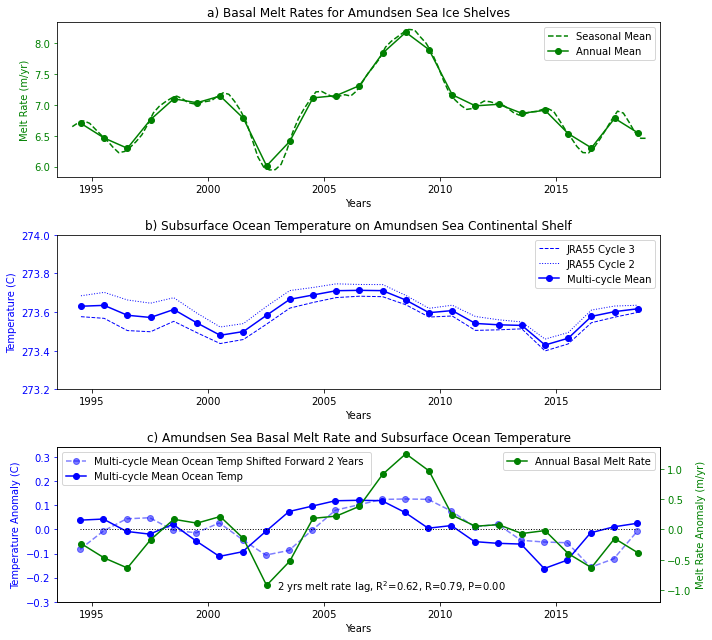

In [41]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
myr=36
maxlag=5

as_t=as_t_200to1000

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(as_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

#shifted by 2 years back
ts_t2=np.mean(as_t[:,myr-2:-2],axis=0)
l_t2=np.mean(ts_t2) #shelf,wap,bs,as,mb
print(ts_t2.shape,yrs[myr-2:-2].shape,yrs[myr-2:-2])


ax1=plt.subplot(311)
ax1.plot(as_mr[1:,0],as_mr[1:,1],linestyle='--',color='g',linewidth=1.5,label='Seasonal Mean')
ax1.plot(as_mr_yr[:,0],as_mr_yr[:,1],linestyle='-',color='g',marker='o',linewidth=1.5,label='Annual Mean')
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
plt.xlim((yrs[myr]-1,yrs[-1]+1))
ax1.set_ylabel('Melt Rate (m/yr)',color='g')
ax1.tick_params('y', colors='g')
plt.title('a) Basal Melt Rates for Amundsen Sea Ice Shelves')
ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(312)
ax1.plot(as_mr_yr[:,0],as_t[1,myr:],linestyle='--',color='b',linewidth=1,label='JRA55 Cycle 3')
ax1.plot(as_mr_yr[:,0],as_t[0,myr:],linestyle=':',color='b',linewidth=1,label='JRA55 Cycle 2')
ax1.plot(as_mr_yr[:,0],np.mean(as_t[:,myr:],axis=0),linestyle='-',color='b',marker='o',linewidth=1.5,label='Multi-cycle Mean')
#ax1.plot(as_mr_yr[:,0],as_t_200to500[1,myr:],linestyle=':',color='y',linewidth=1,label='Cycle 3')
#ax1.plot(as_mr_yr[:,0],as_t_200to500[0,myr:],linestyle=':',color='m',linewidth=1,label='Cycle 2')
#ax1.plot(as_mr_yr[:,0],np.mean(as_t_200to500[:,myr:],axis=0),linestyle=':',color='b',linewidth=1.5,label='MMM')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((273.2,274.0))
plt.xlim((yrs[myr]-1,yrs[-1]+1))
ax1.set_ylabel('Temperature (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('b) Subsurface Ocean Temperature on Amundsen Sea Continental Shelf')
ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(313)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t2-l_t2,linestyle='--',color='b',marker='o',linewidth=1.5,alpha=0.5,label='Multi-cycle Mean Ocean Temp Shifted Forward 2 Years ')
ax1.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Multi-cycle Mean Ocean Temp')
ax1.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.3,.3))
plt.xlim((yrs[myr]-1,yrs[-1]+1))
ax1.set_ylabel('Temperature Anomaly (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('c) Amundsen Sea Basal Melt Rate and Subsurface Ocean Temperature')
ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(as_mr_yr[:,0],as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0),linestyle='-',color='g',marker='o',linewidth=1.5,label='Annual Basal Melt Rate')
ax2.set_ylabel('Melt Rate Anomaly (m/yr)',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.tick_params('y', colors='g')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)
ax2.legend(fontsize=10,loc='upper right')

b=ts_t-l_t
#b=ts_t

#annual mean melrate
a=as_mr_yr[:,1]
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
#corstr="%.0f:2018, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
corstr="%.0f yrs melt rate lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2003,-.25,corstr,color='k')
corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(2004,-0.25,corstr,color='b')

b=ts_t2-l_t2
a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)
#print(a.shape,b.shape)
c= sp.stats.linregress(a,b)
#print(c)
corstr="shifted 1992-2016, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
#ax1.text(2004,-0.15,corstr,color='c')

plt.tight_layout()

of = 'data/ASmelt_w_Temp.png'
plt.savefig(of,dpi=220)

(25,) (25,) [1992.5 1993.5 1994.5 1995.5 1996.5 1997.5 1998.5 1999.5 2000.5 2001.5
 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5 2010.5 2011.5
 2012.5 2013.5 2014.5 2015.5 2016.5]
LinregressResult(slope=5.018214410297933, intercept=-5.6730748500489576e-14, rvalue=0.7759865062283138, pvalue=5.156544356393791e-06, stderr=0.8505268857384931, intercept_stderr=0.06586634986307975)


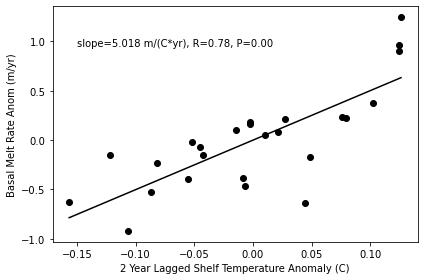

In [42]:
#do a scatter plot linear regression

#shifted by 2 years back (to max lag)
ts_t2=np.mean(as_t[:,myr-2:-2],axis=0)
l_t2=np.mean(ts_t2) #shelf,wap,bs,as,mb
print(ts_t2.shape,yrs[myr-2:-2].shape,yrs[myr-2:-2])

b=ts_t2-l_t2
a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)
c= sp.stats.linregress(b,a)
corstr="shifted 1992-2016, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
print(c) 

#create linear fit line from regression data
mn=np.min(b)
mx=np.max(b)
x1=np.linspace(mn,mx,500)
y1=c.slope*x1+c.intercept
#plt.plot(x,y,'ob')
#ax1.text(1958+myr,-0.25,corstr,color='c')

ax1=plt.subplot(111)
ax1.scatter(b, a,color='k')
ax1.set_xlabel('2 Year Lagged Shelf Temperature Anomaly (C)')
ax1.set_ylabel('Basal Melt Rate Anom (m/yr)')
ax1.plot(x1,y1,'-k')

corstr="slope=%.3f m/(C*yr), R=%.2f, P=%.2f" %(c.slope,c.rvalue,c.pvalue)
ax1.text(-0.15,.95,corstr,color='k')

#plt.title('Amundsen Basal Melt Rate and Subsurface Shelf Temperature Linear Regression')
plt.tight_layout()

of = 'data/ScatReg_Temp_ASmelt.png'
plt.savefig(of,dpi=220)

In [176]:
#do 2d correlation and lag spatial maps
t_zavg_200to1000=[]

f=xr.open_dataset('data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
t_zavg_200to1000.append(f.t_zavg)
f=xr.open_dataset('data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
t_zavg_200to1000.append(f.t_zavg)

t_zavg_200to1000=np.asarray(t_zavg_200to1000)
print(t_zavg_200to1000.shape)


(2, 61, 584, 3600)


In [94]:
print(coef)

[0.24552472 0.5728044  0.76049985 0.76092324 0.63289227 0.44762325
 0.15835452]


In [95]:
#take mmm and just 1994-2018
t_zavg_mmm=np.mean(t_zavg_200to1000[:,myr:,:,:],axis=0)
print(t_zavg_mmm.shape)

(25, 584, 3600)


In [ ]:
#store at max cor the pvalue, lag, tstat
allstats2d = np.full([4, t_zavg.shape[1], t_zavg.shape[2]], np.nan)
print(allstats2d.shape)

#annual mean melrate
a=as_mr_yr[:,1]

for j in range(0,t_zavg_mmm.shape[1]):
    print(j)
    for i in range(0,t_zavg_mmm.shape[2]):
        
        b=t_zavg_mmm[:,j,i]

        if np.isnan(b[0])== False:
            #print(b)
            ## Assumes b is leading
            coef, signif, Neff, Neff2 = pearsoncor(b,a)
            lag = coef.argmax() 
            T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
        
            allstats2d[0,j,i]=coef[lag]
            allstats2d[1,j,i]=signif[lag]
            allstats2d[2,j,i]=lag
            allstats2d[3,j,i]=T
            
a=np.save('data/allstats2d_temp_zavg_200to1000m_01deg_5801to1812.nc.npy',allstats2d)

In [200]:
#for plotting convert allstats2d to xarray dataset
f=xr.open_dataset('data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
allstats2d_xr=f.t_zavg.mean(dim='time').load()

allstats2d=np.load('data/allstats2d_temp_zavg_200to1000m_01deg_5801to1812.nc.npy')

In [201]:
##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #

In [202]:
print(allstats2d_sig.shape)

(4, 584, 3600)


In [203]:
#as_mask2 = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
#as_mask2 = as_mask2.where(~xr.ufuncs.isfinite(as_mask2.where(yt_ocean>-60)))
#as_mask2=as_mask2.where(~xr.ufuncs.isfinite(as_mask2.where(xt_ocean<-137)))
#as_mask2=as_mask2.where(~xr.ufuncs.isfinite(as_mask2.where(xt_ocean>-102)))


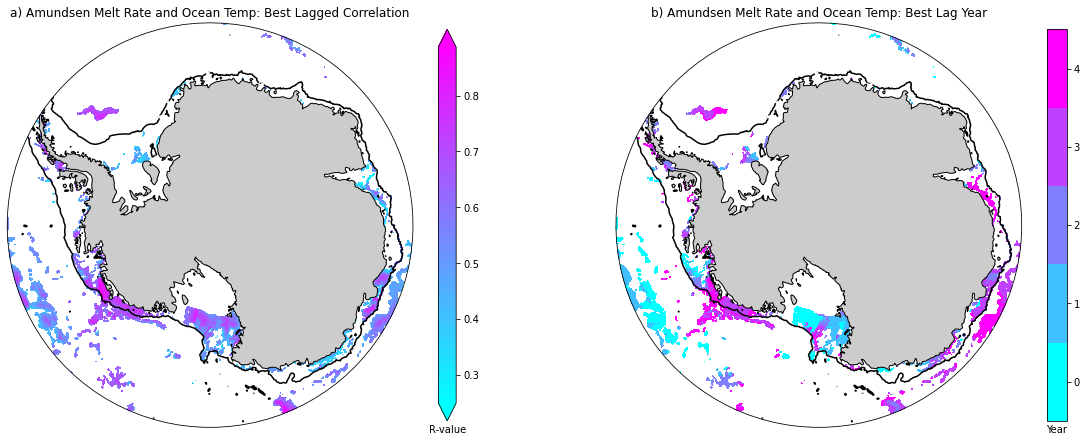

In [204]:
fig = plt.figure(figsize=(20, 18))

projection=ccrs.SouthPolarStereo()

#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -63], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4,extend='both')
cb.ax.set_xlabel('R-value')
plt.title('a) Amundsen Melt Rate and Ocean Temp: Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -63], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('Year')
plt.title('b) Amundsen Melt Rate and Ocean Temp: Best Lag Year')

plt.tight_layout()

of = 'data/2DCor_Temp_ASmelt.png'
plt.savefig(of,dpi=220)

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


Text(0.5, 1.0, 'Masked Temp/Melt Best Lagged Correlation')

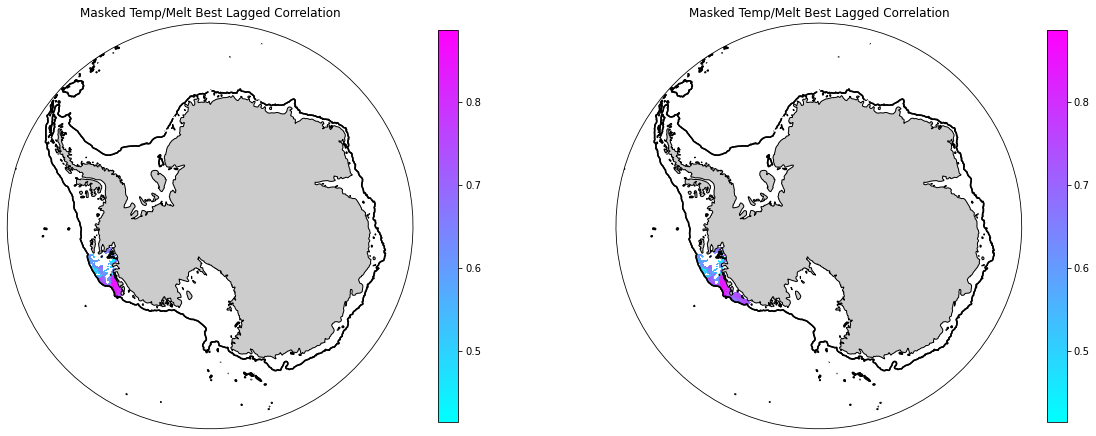

In [181]:
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 2, 1, projection=projection)
ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.where(as_mask.as_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('Masked Temp/Melt Best Lagged Correlation')

ax = plt.subplot(1, 2, 2, projection=projection)
ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.where(as_mask2.as_mask2).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('Masked Temp/Melt Best Lagged Correlation')


(4, 583, 3600)
(4, 583, 3600)


Text(0.5, 1.0, '1980 to 2018 Taux/ASTemp Best Lag')

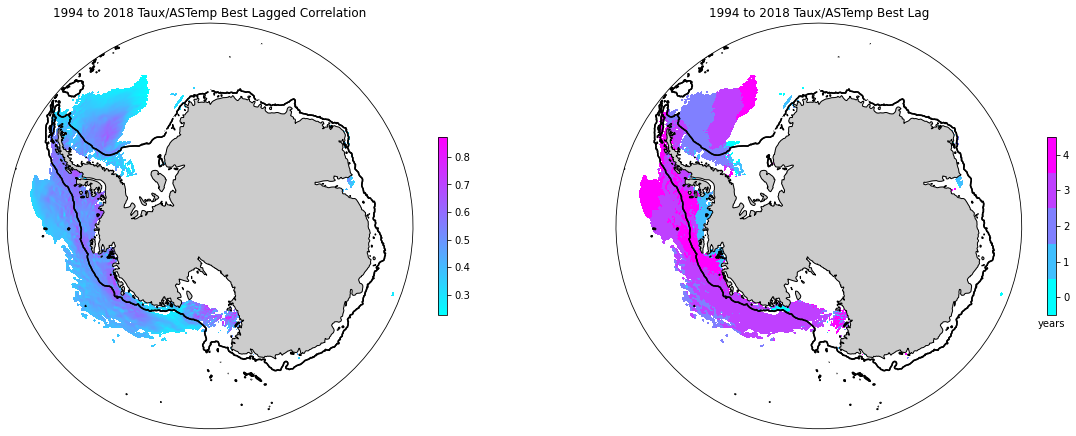

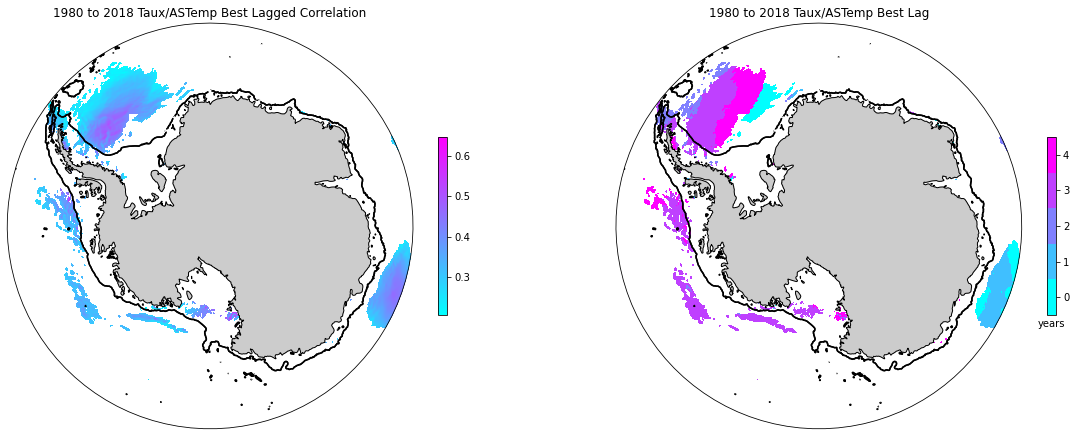

In [94]:
f=xr.open_dataset('data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
allstats2d_xr=f.tau_x.mean(dim='time').load()

allstats2d=np.load('data/allstats2d_taux_w_astemp_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1994 to 2018 Taux/ASTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1994 to 2018 Taux/ASTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))

allstats2d=np.load('data/allstats2d_taux_w_astemp_01deg_80to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 3, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1980 to 2018 Taux/ASTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 4, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1980 to 2018 Taux/ASTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


(4, 583, 3600)


Text(0.5, 1.0, '1994 to 2018 Taux/ASMelt Best Lag')

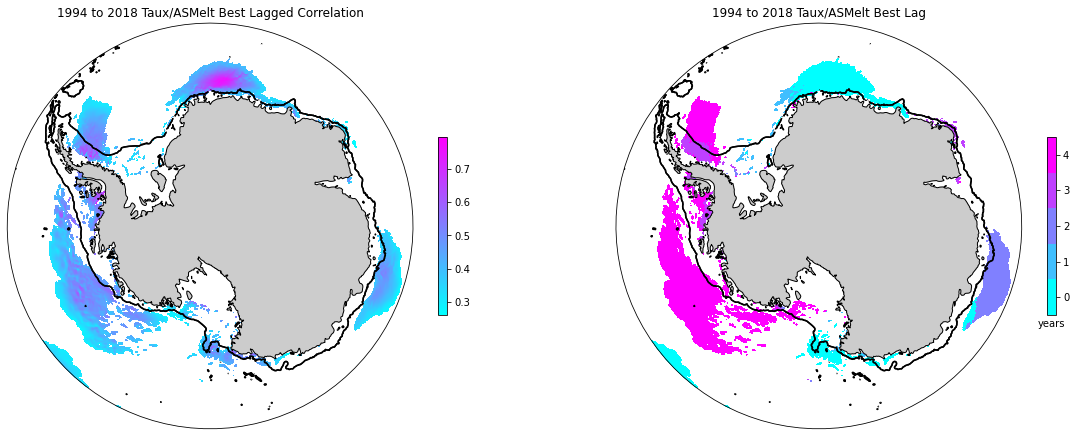

In [183]:
allstats2d=np.load('data/allstats2d_taux_w_asmr_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 3, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1994 to 2018 Taux/ASMelt Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 4, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1994 to 2018 Taux/ASMelt Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


(4, 584, 3600)
(4, 584, 3600)


Text(0.5, 1.0, '1980 to 2018 SSH/ASTemp Best Lag')

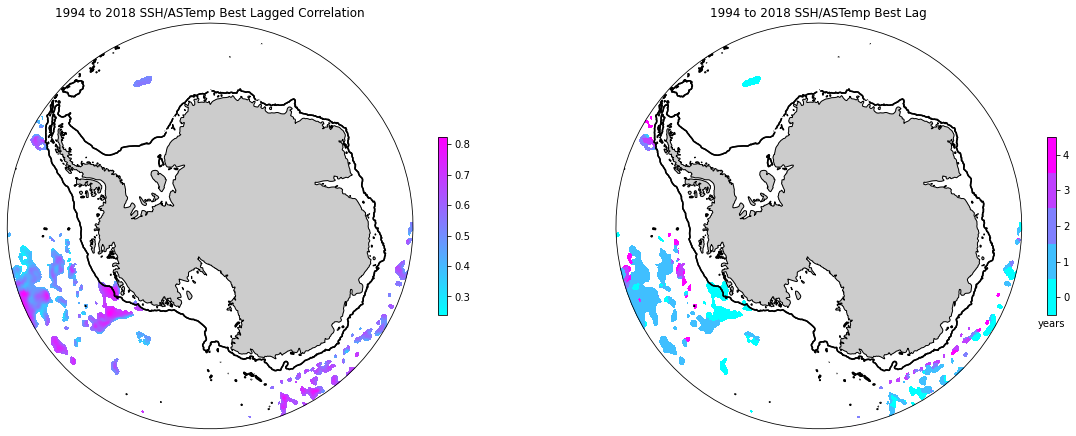

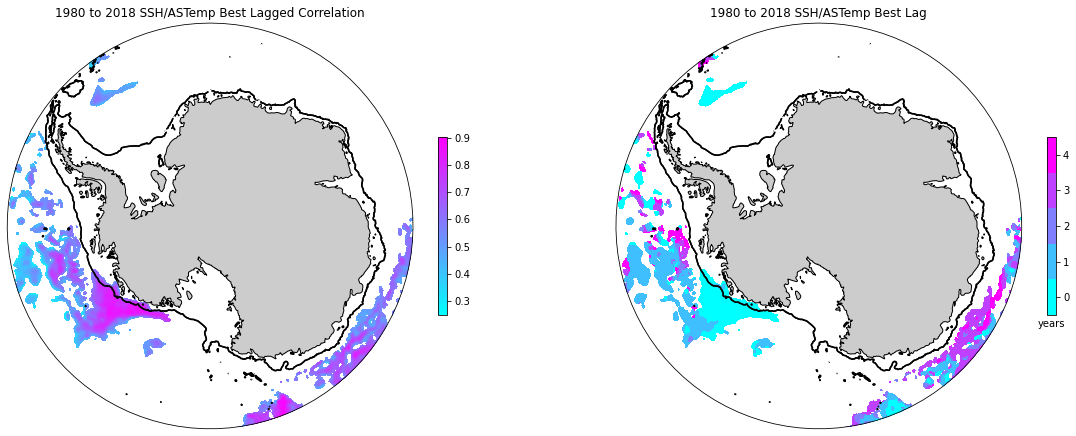

In [184]:
f=xr.open_dataset('data/ssh_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
allstats2d_xr=f.ssh.mean(dim='time').load()

allstats2d=np.load('data/allstats2d_ssh_w_astemp_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1994 to 2018 SSH/ASTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1994 to 2018 SSH/ASTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


allstats2d=np.load('data/allstats2d_ssh_w_astemp_01deg_80to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 3, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1980 to 2018 SSH/ASTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 4, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1980 to 2018 SSH/ASTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


(4, 584, 3600)


Text(0.5, 1.0, '1994 to 2018 SSH/ASMelt Best Lag')

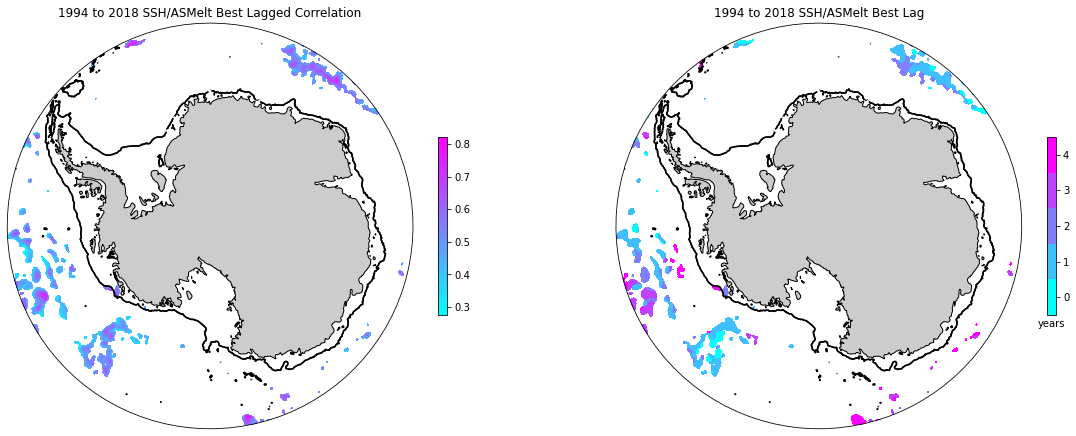

In [185]:
allstats2d=np.load('ensoant/data/allstats2d_ssh_w_asmr_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 3, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('1994 to 2018 SSH/ASMelt Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(2, 2, 4, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('1994 to 2018 SSH/ASMelt Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


In [52]:
#Look at SACCF front position correlations
saccf=np.load('data/01iafAS1.8Clines.npy')

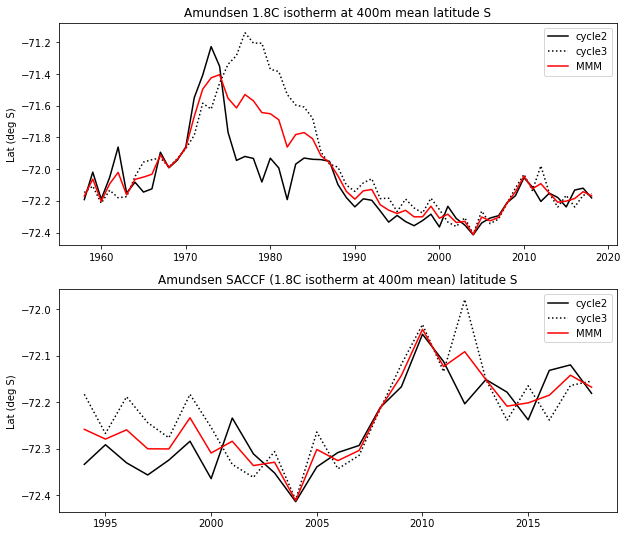

In [53]:
yrs=np.arange(1958,2019)
  
fig = plt.figure(figsize=(10, 9))
ax1=plt.subplot(211)
#aa=np.nans(61,1)
ax1.plot(yrs[:],saccf[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],saccf[:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[:],np.mean(saccf,axis=1),linestyle='-',color='r',label='MMM',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Amundsen 1.8C isotherm at 400m mean latitude S')
ax1.set_ylabel('Lat (deg S)')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

myr=36
ax1=plt.subplot(212)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],saccf[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],saccf[myr:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1),linestyle='-',color='r',label='MMM',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Amundsen SACCF (1.8C isotherm at 400m mean) latitude S')
ax1.set_ylabel('Lat (deg S)')
ax1.legend(fontsize=10)

In [54]:
saccf.shape
yrs[:]

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

No handles with labels found to put in legend.


(61,) ()
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
(25, 2) (25,) [1990.5 1991.5 1992.5 1993.5 1994.5 1995.5 1996.5 1997.5 1998.5 1999.5
 2000.5 2001.5 2002.5 2003.5 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5
 2010.5 2011.5 2012.5 2013.5 2014.5]
(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


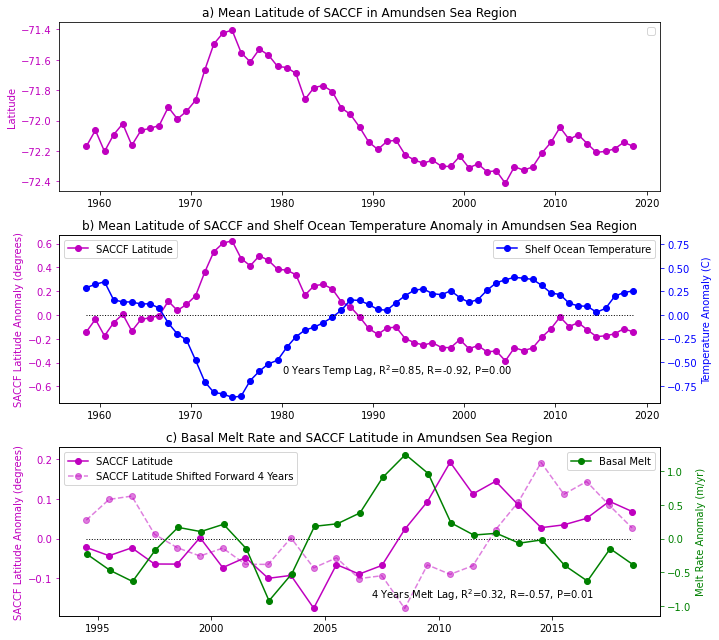

In [55]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
yrs=np.arange(1958.5,2019.5)

myr=0
maxlag=5

as_t=as_t_200to1000_v2

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(as_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

ax1=plt.subplot(311)
#ax1.plot(yrs[:],np.mean(saccf[:,:],axis=1),linestyle='-',color='k',marker='o',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1),linestyle='-',color='m',marker='o',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude',color='m')
ax1.tick_params('y', colors='m')
plt.title('a) Mean Latitude of SACCF in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.set_ylabel('SACCF Latitude Anomaly (degrees)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ts_t-l_t

#annual mean saccf position
b=np.mean(saccf[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="%.0f Years Temp Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-0.5,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

myr=36

#shifted by 2 years back
ts_t2=saccf[myr-4:-4,:]
print(ts_t2.shape,yrs[myr-4:-4].shape,yrs[myr-4:-4])

ax1=plt.subplot(313)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5,label='SACCF Latitude')
ax1.plot(yrs[myr:],np.mean(ts_t2,axis=1)-np.mean(np.mean(ts_t2,axis=1)),linestyle='--',color='m',marker='o',linewidth=1.5,alpha=0.5,label='SACCF Latitude Shifted Forward 4 Years')
ax1.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
ax1.set_ylabel('SACCF Latitude Anomaly (degrees)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('c) Basal Melt Rate and SACCF Latitude in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
#ax2.plot(as_mr[1:,0],as_mr[1:,1]-np.mean(as_mr[1:,1],axis=0),linestyle='--',color='g',linewidth=1.5)
ax2.plot(as_mr_yr[:,0],as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0),linestyle='-',color='g',marker='o',linewidth=1.5,label='Basal Melt')
ax2.set_ylabel('Melt Rate Anomaly (m/yr)',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.tick_params('y', colors='g')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
ax2.legend(fontsize=10,loc='upper right')
align_yaxis_np(ax1,ax2)

#cycle mean of annual mean saccf position
b=np.mean(saccf[myr:,:],axis=1)

#annual mean melrate
a=as_mr_yr[:,1]
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="%.0f Years Melt Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(2007,-0.15,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.1,corstr,color='k')

b=np.mean(ts_t2,axis=1)-np.mean(np.mean(ts_t2,axis=1))
a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)
##print(a.shape,b.shape)
c= sp.stats.linregress(a,b)
#print(c)
corstr="shifted 1990-2014, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
#ax1.text(1958+myr,0.2,corstr,color='k')

plt.tight_layout()

of = 'data/SACCF_Temp_ASmelt.png'
plt.savefig(of,dpi=220)


In [140]:
print(ERSST_ipo_ann)

[[-0.21133333]
 [-0.16583333]
 [-0.16108333]
 [-0.17975   ]
 [-0.19616667]
 [-0.18816667]
 [-0.14891667]
 [-0.09966667]
 [-0.073     ]
 [-0.08133333]
 [-0.12366667]
 [-0.19416667]
 [-0.28466667]
 [-0.38341667]
 [-0.46633333]
 [-0.51241667]
 [-0.50483333]
 [-0.43458333]
 [-0.31475   ]
 [-0.16883333]
 [-0.01266667]
 [ 0.13158333]
 [ 0.23533333]
 [ 0.28966667]
 [ 0.30841667]
 [ 0.30291667]
 [ 0.27233333]
 [ 0.21741667]
 [ 0.15166667]
 [ 0.097     ]
 [ 0.07583333]
 [ 0.102     ]
 [ 0.16866667]
 [ 0.25208333]
 [ 0.33441667]
 [ 0.39525   ]
 [ 0.40183333]
 [ 0.33425   ]
 [ 0.20225   ]
 [ 0.03766667]
 [-0.12041667]
 [-0.23708333]
 [-0.29108333]
 [-0.27866667]
 [-0.21925   ]
 [-0.15166667]
 [-0.11008333]
 [-0.1205    ]
 [-0.18475   ]
 [-0.278     ]
 [-0.3735    ]
 [-0.447     ]
 [-0.47475   ]
 [-0.44116667]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]
 [        nan]]


(61,) ()
(54, 1) (54,)

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


array([[-1.33834003e-01,  3.34638778e-01],
       [-3.57180756e-02,  7.99563556e-01],
       [ 9.13896440e-02,  5.19348167e-01],
       [ 2.21688034e-01,  1.17947993e-01],
       [ 3.48843270e-01,  1.30337367e-02],
       [ 4.65418046e-01,  7.52383651e-04],
       [ 5.69487734e-01,  2.39668175e-05],
       [ 6.55589829e-01,  5.69389832e-07],
       [ 7.18604375e-01,  1.86921385e-08],
       [ 7.62726417e-01,  1.13359273e-09],
       [ 7.84828305e-01,  2.87746262e-10],
       [ 7.86010196e-01,  4.24720371e-10],
       [ 7.67512986e-01,  3.02961546e-09],
       [ 7.35410843e-01,  4.33515130e-08],
       [ 6.92069033e-01,  7.55904018e-07],
       [ 6.45369907e-01,  9.16992347e-06]])

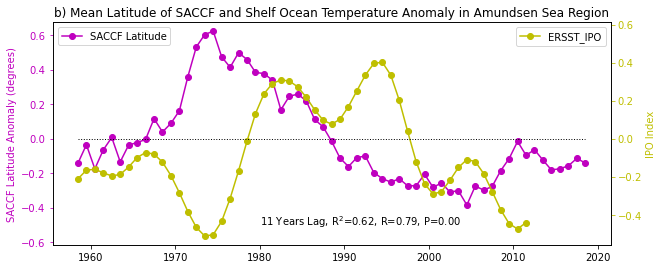

In [152]:
yrs=np.arange(1958.5,2019.5)

myr=0
maxlag=15

as_t=as_t_200to1000_v2

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(as_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

ax1=plt.subplot(212)
ax1.plot(yrs[myr:],np.mean(saccf[myr:,:],axis=1)-np.mean(np.mean(saccf[myr:,:],axis=1)),linestyle='-',color='m',marker='o',linewidth=1.5, label='SACCF Latitude')
ax1.set_ylabel('SACCF Latitude Anomaly (degrees)',color='m')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='m')
plt.title('b) Mean Latitude of SACCF and Shelf Ocean Temperature Anomaly in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
#plt.plot(ERSST_ipoyrd[ERSST_yri:],ERSST_ipo[ERSST_yri:],linestyle='-',color='b',label='ERSST_IPO',linewidth=1.5)
ax2.plot(yrs[myr:-1],ERSST_ipo_ann,linestyle='-',color='y',marker='o',label='ERSST_IPO',linewidth=1.5)
#ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Amundsen Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('IPO Index',color='y')
ax2.tick_params('y', colors='y')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)


a=ERSST_ipo_ann[:-6]

#annual mean saccf position
b=np.mean(saccf[myr:-7,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a[:,0],b,maxlag)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f Years Lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-0.5,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,0.5,corstr,color='k')

l

In [27]:
## a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)

#annual mean saccf position
b=np.mean(saccf[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
l

(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


array([[ 0.10976519,  0.6014539 ],
       [-0.12845204,  0.54972177],
       [-0.30108316,  0.16269513],
       [-0.51890541,  0.01334135],
       [-0.56911722,  0.00709006],
       [-0.5610508 ,  0.01006225]])

In [56]:
#Look at Taux=0 front position correlations
tx0=np.load('data/01iafTx0lines.npy')
tx0=np.load('data/01iafTx0_83wlines.npy')
tx0.shape


(61, 2)

In [63]:
#df= pd.DataFrame(hadsst_n34_ann)
#hadsst_n34_ann_5yr = df.rolling(window=5, center=True).mean().values
#print(hadsst_n34_ann.shape,hadsst_n34_ann_5yr.shape)

#non-centered rolling ... keep data to 2019
tx0_all = pd.DataFrame(np.mean(tx0,axis=1),columns=['MMM'])
tx0_all
tx0_all['Rolling']=tx0_all['MMM'].rolling(window=5).mean()
tx0_all
tx0_all['Rolling'][:]

0           NaN
1           NaN
2           NaN
3           NaN
4    -69.856053
        ...    
56   -69.610087
57   -69.924122
58   -70.519768
59   -70.594901
60   -70.604388
Name: Rolling, Length: 61, dtype: float64

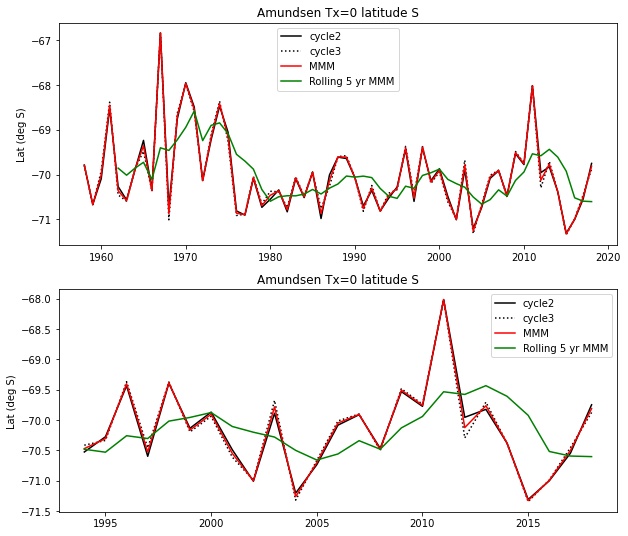

In [64]:
#non-centered rolling ... keep data to 2019
yrs=np.arange(1958,2019)
  
fig = plt.figure(figsize=(10, 9))
ax1=plt.subplot(211)
#aa=np.nans(61,1)
ax1.plot(yrs[:],tx0[:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[:],tx0[:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[:],np.mean(tx0,axis=1),linestyle='-',color='r',label='MMM',linewidth=1.5)
ax1.plot(yrs[:],tx0_all['Rolling'],linestyle='-',color='g',label='Rolling 5 yr MMM',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Amundsen Tx=0 latitude S')
ax1.set_ylabel('Lat (deg S)')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

myr=36
ax1=plt.subplot(212)
#aa=np.nans(61,1)
ax1.plot(yrs[myr:],tx0[myr:,0],linestyle='-',color='k',label='cycle2',linewidth=1.5)
ax1.plot(yrs[myr:],tx0[myr:,1],linestyle=':',color='k',label='cycle3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1),linestyle='-',color='r',label='MMM',linewidth=1.5)
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='g',label='Rolling 5 yr MMM',linewidth=1.5)

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
#ax1.tick_params('y', colors='b')
plt.title('Amundsen Tx=0 latitude S')
ax1.set_ylabel('Lat (deg S)')
ax1.legend(fontsize=10)

(61,) ()
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]
(25,) (25,) [1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]


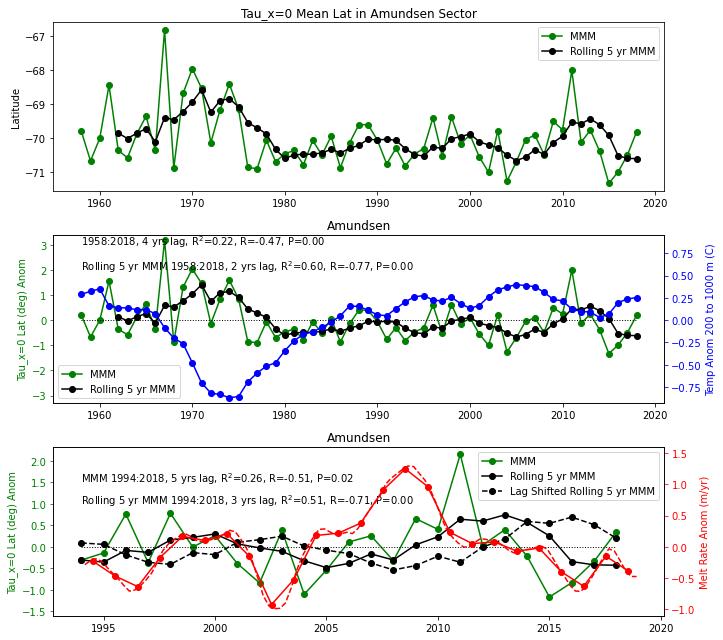

In [65]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
myr=0
maxlag=10

as_t=as_t_200to1000_v2

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(as_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

ax1=plt.subplot(311)
ax1.plot(yrs[:],np.mean(tx0[:,:],axis=1),linestyle='-',color='g',marker='o',linewidth=1.5,label='MMM')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling 5 yr MMM')

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude',color='k')
#ax1.tick_params('y', colors='b')
plt.title('Tau_x=0 Mean Lat in Amundsen Sector')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='-',color='g',marker='o',linewidth=1.5,label='MMM')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.mean(tx0_all['Rolling'][myr:]),linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling 5 yr MMM')
ax1.set_ylabel('Tau_x=0 Lat (deg) Anom',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='g')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5)
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temp Anom 200 to 1000 m (C)',color='b')
ax2.tick_params('y', colors='b')

align_yaxis_np(ax1,ax2)

a=ts_t-l_t

#annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="%.0f:2018, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,3.,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,2.,corstr,color='k')

#cycle mean of annual mean saccf position #use -2 if rolling centered
b=tx0_all['Rolling'][myr+4:]

#lagged cor, a lags b
l=lagcorr(a[4:],b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Rolling 5 yr MMM %.0f:2018, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,2,corstr,color='k')
#

myr=36

#shifted by 2 years back
#ts_t2=tx0[myr-5:-5,:]
#np.mean(ts_t2,axis=1)-np.mean(np.mean(ts_t2,axis=1))
ts_t2=tx0_all['Rolling'][myr-3:-3]
print(ts_t2.shape,yrs[myr:].shape,yrs[myr:])

ax1=plt.subplot(313)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='-',color='g',marker='o',linewidth=1.5,label='MMM')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.mean(tx0_all['Rolling'][myr:]),linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling 5 yr MMM')
ax1.plot(yrs[myr:],ts_t2-np.mean(ts_t2),linestyle='--',color='k',marker='o',linewidth=1.5,label='Lag Shifted Rolling 5 yr MMM')
ax1.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
ax1.set_ylabel('Tau_x=0 Lat (deg) Anom',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='g')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(as_mr[1:,0],as_mr[1:,1]-np.mean(as_mr[1:,1],axis=0),linestyle='--',color='r',linewidth=1.5)
ax2.plot(as_mr_yr[:,0],as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0),linestyle='-',color='r',marker='o',linewidth=1.5)
ax2.set_ylabel('Melt Rate Anom (m/yr)',color='r')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.tick_params('y', colors='r')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#cycle mean of annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)

#annual mean melrate
a=as_mr_yr[:,1]
print(a.shape,b.shape)

#lagged cor, a lags b 
l=lagcorr(a[:],b[:],maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="MMM %.0f:2018, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,1.5,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,1.,corstr,color='k')

#cycle mean of annual mean saccf position
b=tx0_all['Rolling'][myr:]

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Rolling 5 yr MMM %.0f:2018, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,1,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,1.,corstr,color='k')


#b=np.mean(ts_t2,axis=1)-np.mean(np.mean(ts_t2,axis=1))
#a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)
##print(a.shape,b.shape)
#c= sp.stats.linregress(a,b)
##print(c)
##corstr="shifted 1992-2016, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
##ax1.text(1958+myr,1.5,corstr,color='c')

plt.tight_layout()

In [66]:
#df= pd.DataFrame(hadsst_n34_ann)
#hadsst_n34_ann_5yr = df.rolling(window=5, center=True).mean().values
#print(hadsst_n34_ann.shape,hadsst_n34_ann_5yr.shape)

#non-centered rolling ... keep data to 2019
tx0_all = pd.DataFrame(np.mean(tx0,axis=1),columns=['MMM'])
tx0_all
tx0_all['Rolling']=tx0_all['MMM'].rolling(window=5, center=True).mean()
tx0_all
tx0_all['Rolling'][:]

0           NaN
1           NaN
2    -69.856053
3    -70.013807
4    -69.855512
        ...    
56   -70.519768
57   -70.594901
58   -70.604388
59          NaN
60          NaN
Name: Rolling, Length: 61, dtype: float64

(61,) ()
(61,) (61,)

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]
(25,) (25,) [1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
(25,) (25,)

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]

#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10]


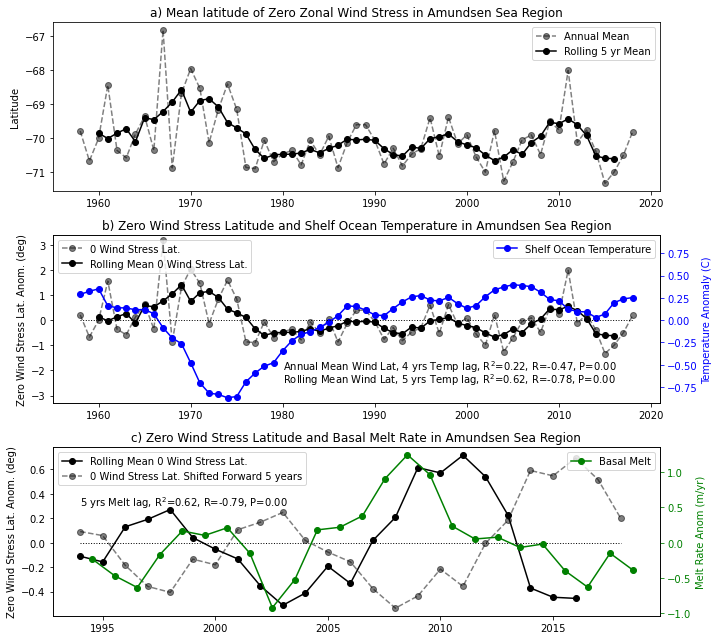

In [96]:
#Rolling mean = centered =2 ... lose lat 2 datapoints

#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
myr=0
maxlag=10

as_t=as_t_200to1000_v2

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(as_t[:,myr:],axis=0)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

ax1=plt.subplot(311)
ax1.plot(yrs[:],np.mean(tx0[:,:],axis=1),linestyle='--',color='k',marker='o',linewidth=1.5,alpha=0.5,label='Annual Mean')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:],linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling 5 yr Mean')

#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Latitude',color='k')
#ax1.tick_params('y', colors='b')
plt.title('a) Mean latitude of Zero Zonal Wind Stress in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(312)
ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='--',color='k',alpha=0.5,marker='o',linewidth=1.5,label='0 Wind Stress Lat.')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.mean(tx0_all['Rolling'][myr:]),linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling Mean 0 Wind Stress Lat.')
ax1.set_ylabel('Zero Wind Stress Lat. Anom. (deg)',color='k')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='k')
plt.title('b) Zero Wind Stress Latitude and Shelf Ocean Temperature in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5,label='Shelf Ocean Temperature')
ax2.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.3,.3))
ax2.set_ylabel('Temperature Anomaly (C)',color='b')
ax2.tick_params('y', colors='b')
ax2.legend(fontsize=10,loc='upper right')

align_yaxis_np(ax1,ax2)

a=ts_t-l_t

#annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)
#a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Annual Mean Wind Lat, %.0f yrs Temp lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-2.,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,2.,corstr,color='k')

#cycle mean of annual mean saccf position #use -2 if rolling centered
b=tx0_all['Rolling'][myr+4:-2]

#lagged cor, a lags b
l=lagcorr(a[4:-2],b,maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="Rolling Mean Wind Lat, %.0f yrs Temp lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1980,-2.5,corstr,color='k')
#

myr=36

#shifted by 2 years back
#ts_t2=tx0[myr-5:-5,:]
#np.mean(ts_t2,axis=1)-np.mean(np.mean(ts_t2,axis=1))
ts_t2=tx0_all['Rolling'][myr-5:-5]
print(ts_t2.shape,yrs[myr:].shape,yrs[myr:])

ax1=plt.subplot(313)
#ax1.plot(yrs[myr:],np.mean(tx0[myr:,:],axis=1)-np.mean(np.mean(tx0[myr:,:],axis=1)),linestyle='-',color='g',marker='o',linewidth=1.5,label='MMM')
ax1.plot(yrs[myr:],tx0_all['Rolling'][myr:]-np.mean(tx0_all['Rolling'][myr:]),linestyle='-',color='k',marker='o',linewidth=1.5,label='Rolling Mean 0 Wind Stress Lat.')
ax1.plot(yrs[myr:],ts_t2-np.mean(ts_t2),linestyle='--',color='k',marker='o',alpha=0.5,linewidth=1.5,label='0 Wind Stress Lat. Shifted Forward 5 years')
ax1.plot(yrs[myr:],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
ax1.set_ylabel('Zero Wind Stress Lat. Anom. (deg)',color='k')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax1.tick_params('y', colors='k')
plt.title('c) Zero Wind Stress Latitude and Basal Melt Rate in Amundsen Sea Region')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10,loc='upper left')

ax2=ax1.twinx()
#ax2.plot(as_mr[1:,0],as_mr[1:,1]-np.mean(as_mr[1:,1],axis=0),linestyle='--',color='g',linewidth=1.5)
ax2.plot(as_mr_yr[:,0],as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0),linestyle='-',color='g',marker='o',linewidth=1.5,label='Basal Melt')
ax2.set_ylabel('Melt Rate Anom (m/yr)',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.tick_params('y', colors='g')
ax2.legend(fontsize=10,loc='upper right')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#cycle mean of annual mean saccf position
b=np.mean(tx0[myr:,:],axis=1)

#annual mean melrate
a=as_mr_yr[:,1]
print(a.shape,b.shape)

#lagged cor, a lags b -2 if rolling centered
l=lagcorr(a[:-2],b[:-2],maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="MMM %.0f:2018, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
#ax1.text(1958+myr,1.5,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,1.,corstr,color='k')

#cycle mean of annual mean saccf position
b=tx0_all['Rolling'][myr:]

#lagged cor, a lags b
l=lagcorr(a[:-2],b[:-2],maxlag)
lmax = np.where(l[:,0] == np.amin(l[:,0]))[0]
corstr="%.0f yrs Melt lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr,color='k')
#corstr="%.0f:2018, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
#ax1.text(1958+myr,1.,corstr,color='k')


#b=np.mean(ts_t2,axis=1)-np.mean(np.mean(ts_t2,axis=1))
#a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)
##print(a.shape,b.shape)
#c= sp.stats.linregress(a,b)
##print(c)
##corstr="shifted 1992-2016, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
##ax1.text(1958+myr,1.5,corstr,color='c')

plt.tight_layout()

of = 'data/Tx0_Temp_ASmelt.png'
plt.savefig(of,dpi=220)

In [74]:
#cycle mean of annual mean saccf position
ts_t2=tx0_all['Rolling'][myr-3:-3]
print(ts_t2.shape,yrs[myr:].shape,yrs[myr:])


(25,) (25,) [1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


In [22]:
#plot ASL correlations
asl_df_mask_all = pd.DataFrame(np.load('data/jra55_asl_df_mnth_5801to1812_wnans.npy',allow_pickle=True), 
             columns=['time','lon','lat','ActCenPres','SectorPres','SectorPres'])
asl_df_mask_all

,time,lon,lat,ActCenPres,SectorPres,SectorPres
0,1958-01-31,278.4375,-68.236955,983.171021,989.59137,-6.420349
1,1958-02-28,213.75,-69.921806,987.755798,991.843811,-4.088013
2,1958-03-31,239.625,-63.182389,986.214111,990.699036,-4.484924
3,1958-04-30,289.6875,-65.428865,985.633179,996.040222,-10.407043
4,1958-05-31,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
727,2018-08-31,271.125,-69.360189,979.019043,988.390808,-9.371765
728,2018-09-30,230.625,-71.606655,974.093933,981.382141,-7.288208
729,2018-10-31,212.625,-71.606655,967.571655,978.916443,-11.344788
730,2018-11-30,276.75,-68.798572,970.024536,978.582092,-8.557556


In [ ]:
#processing scratch below

In [89]:
#look for ssh correlations now
ssh=[]

f=xr.open_dataset('data/ssh_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
ssh.append(f.ssh)

f=xr.open_dataset('data/ssh_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
ssh.append(f.ssh)

ssh=np.asarray(ssh)
print(ssh.shape)

(2, 61, 584, 3600)


In [83]:
#melt rate ssh correlations 
myr=36 

#take mmm and just 1994-2018
ssh_mmm=np.mean(ssh[:,myr:,:,:],axis=0)
print(ssh_mmm.shape)

#store at max cor the pvalue, lag, tstat
allstats2d = np.full([4, ssh_mmm.shape[1], ssh_mmm.shape[2]], np.nan)
print(allstats2d.shape)

#annual mean melrate
a=as_mr_yr[:,1]
print(a.shape)
for j in range(0,ssh_mmm.shape[1]):
    #print(j)
    for i in range(0,ssh_mmm.shape[2]):
        
        b=ssh_mmm[:,j,i]

        if np.isnan(b[0])== False:
            #print(b)
            ## Assumes b is leading
            coef, signif, Neff, Neff2 = pearsoncor(b,a)
            lag = coef.argmax() 
            T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
        
            allstats2d[0,j,i]=coef[lag]
            allstats2d[1,j,i]=signif[lag]
            allstats2d[2,j,i]=lag
            allstats2d[3,j,i]=T
            
a=np.save('data/allstats2d_ssh_w_asmr_01deg_94to18.nc.npy',allstats2d)

(25, 584, 3600)
(4, 584, 3600)
(25,)


In [90]:
#Temp SSH correlations 
myr=36
#take mmm and just 1994-2018 or do 1980-2018
ssh_mmm=np.mean(ssh[:,myr:,:,:],axis=0)
print(ssh_mmm.shape)

#store at max cor the pvalue, lag, tstat
allstats2d = np.full([4, ssh_mmm.shape[1], ssh_mmm.shape[2]], np.nan)
print(allstats2d.shape)

#annual mean temp on averaged shelf
a=np.mean(as_t_200to1000_v2[:,myr:],axis=0)

for j in range(0,ssh_mmm.shape[1]):
    print(j)
    for i in range(0,ssh_mmm.shape[2]):
        
        b=ssh_mmm[:,j,i]

        if np.isnan(b[0])== False:
            #print(b)
            ## Assumes b is leading
            coef, signif, Neff, Neff2 = pearsoncor(b,a)
            lag = coef.argmax() 
            T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
        
            allstats2d[0,j,i]=coef[lag]
            allstats2d[1,j,i]=signif[lag]
            allstats2d[2,j,i]=lag
            allstats2d[3,j,i]=T
            
a=np.save('data/allstats2d_ssh_w_astemp_01deg_94to18.nc.npy',allstats2d)

(25, 584, 3600)
(4, 584, 3600)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269

In [18]:
#look for wind correlations now
txx=[]

f=xr.open_dataset('data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
txx.append(f.tau_x)

f=xr.open_dataset('data/taux_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
txx.append(f.tau_x)

txx=np.asarray(txx)
print(txx.shape)

(2, 61, 583, 3600)


In [ ]:
#melt rate Taux correlations 

#take mmm and just 1994-2018
txx_mmm=np.mean(txx[:,myr:,:,:],axis=0)
print(txx_mmm.shape)

#store at max cor the pvalue, lag, tstat
allstats2d = np.full([4, txx_mmm.shape[1], txx_mmm.shape[2]], np.nan)
print(allstats2d.shape)

#annual mean melrate
a=as_mr_yr[:,1]

for j in range(0,txx_mmm.shape[1]):
    #print(j)
    for i in range(0,txx_mmm.shape[2]):
        
        b=txx_mmm[:,j,i]

        if np.isnan(b[0])== False:
            #print(b)
            ## Assumes b is leading
            coef, signif, Neff, Neff2 = pearsoncor(b,a)
            lag = coef.argmax() 
            T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
        
            allstats2d[0,j,i]=coef[lag]
            allstats2d[1,j,i]=signif[lag]
            allstats2d[2,j,i]=lag
            allstats2d[3,j,i]=T
            
a=np.save('data/allstats2d_taux_w_asmr_01deg_.nc.npy',allstats2d)

In [19]:
#Temp Taux correlations 
myr=12
#take mmm and just 1994-2018 or do 1980-2018
txx_mmm=np.mean(txx[:,myr:,:,:],axis=0)
print(txx_mmm.shape)

#store at max cor the pvalue, lag, tstat
allstats2d = np.full([4, txx_mmm.shape[1], txx_mmm.shape[2]], np.nan)
print(allstats2d.shape)

#annual mean temp on averaged shelf
a=np.mean(as_t_200to1000_v2[:,myr:],axis=0)

for j in range(0,txx_mmm.shape[1]):
    #print(j)
    for i in range(0,txx_mmm.shape[2]):
        
        b=txx_mmm[:,j,i]

        if np.isnan(b[0])== False:
            #print(b)
            ## Assumes b is leading
            coef, signif, Neff, Neff2 = pearsoncor(b,a)
            lag = coef.argmax() 
            T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
        
            allstats2d[0,j,i]=coef[lag]
            allstats2d[1,j,i]=signif[lag]
            allstats2d[2,j,i]=lag
            allstats2d[3,j,i]=T
            
a=np.save('data/allstats2d_taux_w_astemp_01deg_70to18.nc.npy',allstats2d)

(49, 583, 3600)
(4, 583, 3600)


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [20]:
j

571

In [72]:
#for plotting convert allstats2d to xarray dataset
f=xr.open_dataset('data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
allstats2d_xr=f.tau_x.mean(dim='time').load()

(4, 583, 3600)


Text(0.5, 1.0, 'Taux/ASTemp Best Lag')

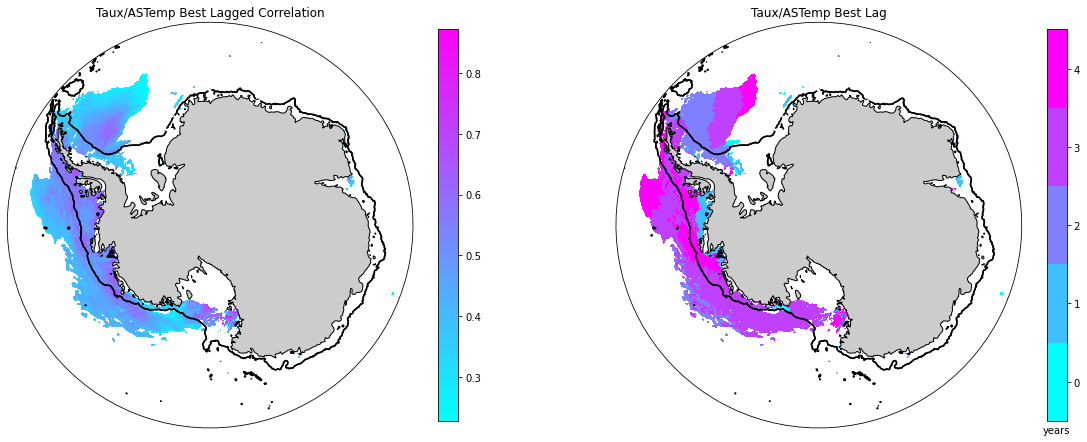

In [73]:
allstats2d=np.load('data/allstats2d_taux_w_astemp_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('Taux/ASTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('Taux/ASTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


(4, 583, 3600)


Text(0.5, 1.0, 'Taux/ASTemp Best Lag')

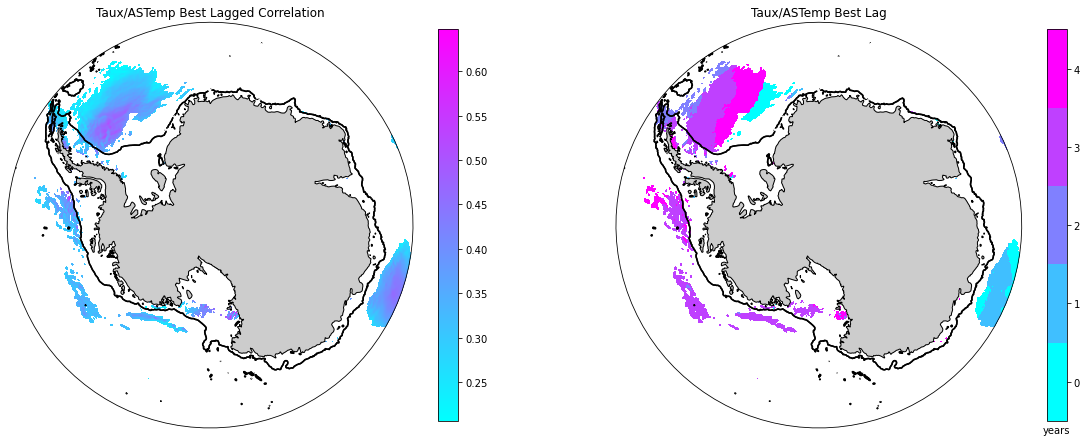

In [76]:
allstats2d=np.load('data/allstats2d_taux_w_astemp_01deg_80to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('Taux/ASTemp Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('Taux/ASTemp Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


(4, 583, 3600)


Text(0.5, 1.0, 'Taux/ASMelt Best Lag')

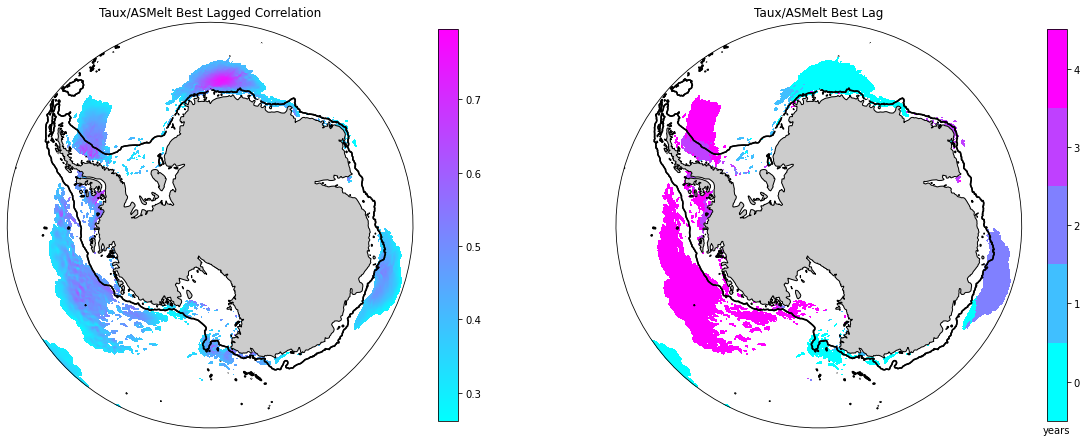

In [74]:
allstats2d=np.load('data/allstats2d_taux_w_asmr_01deg_94to18.nc.npy')

##nan unless p<0.05 and Tstat> and lag <4
allstats2d_sig = np.where((allstats2d[2,:,:]<5) & (allstats2d[3,:,:]>2.0686),allstats2d,np.NaN) #
print(allstats2d_sig.shape)

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(20, 18))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

#plot R coef
allstats2d_xr.values=allstats2d_sig[0,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,orientation='vertical',shrink = 0.4)
plt.title('Taux/ASMelt Best Lagged Correlation')

#plot Best Lag
allstats2d_xr.values=allstats2d_sig[2,:,:]
allstats2d_xr

ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#anom=temp.where(tmask.tmask).sel(st_ocean=(200,700)).mean(dim='st_ocean')
#t=temp.isel(st_ocean=0)


#p1 = ltm_temp_zavg.where(mb_mask.mb_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=271, vmax=274, add_colorbar=False, cmap=plt.cm.seismic, extend='both', transform=ccrs.PlateCarree())
cmap = plt.get_cmap('cool', np.max(allstats2d_xr)-np.min(allstats2d_xr)+1)
p1 = allstats2d_xr.plot.pcolormesh(x='xu_ocean', y='yu_ocean', vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5,add_colorbar=False, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
p2 = ht.plot.contour(ax=ax,
                       x='xt_ocean', y='yt_ocean', levels=2, vmin=999, vmax=1002, colors='k',linewidth=1,
                       transform=ccrs.PlateCarree())
cb=plt.colorbar(p1,ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1),orientation='vertical',shrink = 0.4)
cb.ax.set_xlabel('years')
plt.title('Taux/ASMelt Best Lag')

##get discrete colormap
#cmap = plt.get_cmap('RdBu', np.max(data)-np.min(data)+1)

## set limits .5 outside true range
#mat = plt.matshow(data,cmap=cmap,vmin = np.min(allstats2d_xr)-.5, vmax = np.max(allstats2d_xr)+.5)

##tell the colorbar to tick at integers
#cax = plt.colorbar(mat, ticks=np.arange(np.min(allstats2d_xr),np.max(allstats2d_xr)+1))


In [21]:
#check spatial averaging ... all good
#tz=np.zeros((5,t_zavg.shape[0]))
f=xr.open_dataset('data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
t1=f.t_zavg.where(as_mask.as_mask).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t1.shape)

f=xr.open_dataset('data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
t2=f.t_zavg.where(as_mask.as_mask).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t2.shape)

t=xr.concat([t1,t2],'cycle')
print(t.shape,t1.shape,t2.shape)

t=t.mean(dim='cycle')
print(t.shape,t1.shape,t2.shape)

b=t[myr:]

#annual mean melrate
a=as_mr_yr[:,1]

print(a.shape,b.shape)

## Assumes b is leading
coef, signif, Neff, Neff2 = pearsoncor(b,a)
lag = coef.argmax() 
print('Correlations: %d years, %0.2f, %0.2f'%(lag, coef[lag], signif[lag]))
print('Effective sample size: %d or %d'%(Neff[lag], Neff2))
T = coef[lag]*Neff[lag]**(0.5)*(1-coef[lag]**2)**(-0.5)
print('T-statistic at max correlation: %0.2f '% T)


(61,)
(61,)
(2, 61) (61,) (61,)
(61,) (61,) (61,)
(25,) (25,)
Correlations: 2 years, 0.79, 0.00
Effective sample size: 7 or 5
T-statistic at max correlation: 3.45 


In [48]:
print(as_mr_yr[:,0])
print(yrs[myr:])

[1994.535 1995.535 1996.535 1997.535 1998.535 1999.535 2000.535 2001.535
 2002.535 2003.535 2004.535 2005.535 2006.535 2007.535 2008.535 2009.535
 2010.535 2011.535 2012.535 2013.535 2014.535 2015.535 2016.535 2017.535
 2018.535]
[1994.5 1995.5 1996.5 1997.5 1998.5 1999.5 2000.5 2001.5 2002.5 2003.5
 2004.5 2005.5 2006.5 2007.5 2008.5 2009.5 2010.5 2011.5 2012.5 2013.5
 2014.5 2015.5 2016.5 2017.5 2018.5]


In [12]:
#load the ts temp data
wap_t=np.load('/g/data/v45/pas561/jnb/ensoant/data/01_cyc1to2_200to500_temp_wap_ts.npy')
print(wap_t.shape)

bs_t=np.load('/g/data/v45/pas561/jnb/ensoant/data/01_cyc1to2_200to500_temp_bs_ts.npy')
print(bs_t.shape)

as_t=np.load('/g/data/v45/pas561/jnb/ensoant/data/01_cyc1to2_200to500_temp_as_ts.npy')
print(as_t.shape)

mb_t=np.load('/g/data/v45/pas561/jnb/ensoant/data/01_cyc1to2_200to500_temp_mb_ts.npy')
print(mb_t.shape)

(60, 2)
(60, 2)
(60, 2)
(60, 2)


In [13]:
print(hadsst_n34yr)
print(ERSST_ipoyr)

[[1870]
 [1870]
 [1870]
 ...
 [2018]
 [2018]
 [2018]]
[[1854]
 [1854]
 [1854]
 ...
 [2018]
 [2018]
 [2018]]


In [14]:
#### calc correlations with IPO (last 6 years are nan)
#do amundsen for test
#anoms relative to multi-cycle mean (1958+myr:2017)
#correlations from 1958+myr:2017
myr=0
maxlag=5

#no lag
ts_t=wap_t
#ensemble mean
ts_t=np.mean(ts_t[myr:,:],axis=1)
print(ts_t.shape)
#cycle mean
l_t=np.mean(ts_t)

a=ts_t-l_t
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)

c= sp.stats.linregress(a[:-6],b[:-6])
print(c)

#lagged correlation
l=lagcorr(a[:-6],b[:-6],maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
print("lagged lmax, rcor, pval",lmax[0],l[lmax[0],0],l[lmax[0],1])

#calc lagged linear regression
#rcor, pvalues - same as laggcorr
#a=ts_t[lmax[0]:]-l_t
#print(a.shape)
#b=np.squeeze(ERSST_ipo_ann[myr:-lmax[0]])
#print(a.shape,b.shape)
#c= sp.stats.linregress(a[:-6],b[:-6])
#print(c)
#corstr="regressed R$^2$=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.pvalue)
#print(corstr)

#myr=30 [lag=2, rcor=.22] [lag=12, rcor=.94]
#myr=20 [lag=1, rcor= -ve0.21] [lag=12, rcor=.87]
#myr=10 [lag=3, rcor=.55] [lag=12, rcor=0.72]
#myr=0, [lag=3, rcor=.52] [lag=12,rcor=0.49]

(60,)
LinregressResult(slope=0.1637216553013393, intercept=-0.07393561515874424, rvalue=0.23937319256096434, pvalue=0.0812793624537914, stderr=0.09209070673126271, intercept_stderr=0.035056661033830074)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[0.23937319 0.08127936]
 [0.24906653 0.07210511]
 [0.25215399 0.07133002]
 [0.25289073 0.07338054]
 [0.2510995  0.0785886 ]
 [0.24871131 0.08484721]]
lagged lmax, rcor, pval 3 0.25289072860258094 0.073380544633389



#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[0.26763477 0.07902382]
 [0.26730702 0.08311573]
 [0.25826017 0.09866602]
 [0.25024641 0.11455865]
 [0.23830591 0.1386559 ]
 [0.21344772 0.19199259]]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[0.12130892 0.43279927]
 [0.17936835 0.24977285]
 [0.23056897 0.14182214]
 [0.2648355  0.09425639]
 [0.27459376 0.08639121]
 [0.25797772 0.11282425]]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[0.31556652 0.03692265]
 [0.40100582 0.00769982]
 [0.46147527 0.00209724]
 [0.49605984 0.00097258]
 [0.50809419 0.00081665]
 [0.50500893 0.00104233]]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[0.39610601 0.00777527]
 [0.45508307 0.00216826]
 [0.47891442 0.00133414]
 [0.47412193 0.00173894]
 [0.45264789 0.00336022]
 [0.42483004 0.00702257]]


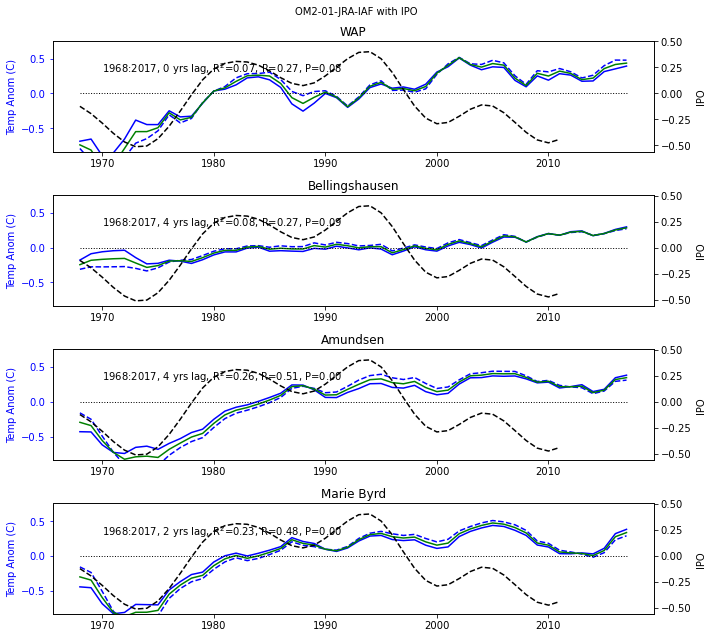

In [14]:
fig = plt.figure(figsize=(10, 9))

plt.suptitle('OM2-01-JRA-IAF with IPO', fontsize=10)

#anoms relative to multi-cycle mean (1958+myr:2017)
myr=10

ts_t=wap_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(411)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],5)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.3,corstr)

ts_t=bs_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(412)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellingshausen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)


#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],5)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.3,corstr)


ts_t=as_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(413)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)


#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],5)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.3,corstr)


ts_t=mb_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(414)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Marie Byrd')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)


#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],5)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1970,0.3,corstr)

plt.tight_layout()


#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[-0.39306753  0.1066025 ]
 [-0.5374755   0.02607551]
 [-0.71823622  0.00172517]
 [-0.76033181  0.00100046]
 [-0.64415824  0.01290459]
 [-0.26791579  0.37616182]]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[-0.63569379  0.00457678]
 [-0.68658117  0.00233422]
 [-0.72314035  0.00154788]
 [-0.65381718  0.00819804]
 [-0.62053473  0.01789138]
 [-0.65988941  0.01411692]]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[ 1.87816858e-01  4.55477863e-01]
 [ 1.34342117e-01  6.07212655e-01]
 [-8.02500804e-02  7.67659382e-01]
 [-3.23749823e-01  2.39139612e-01]
 [-5.86005558e-01  2.76502248e-02]
 [-8.36344179e-01  3.66362292e-04]]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[ 0.3481717   0.15681057]
 [ 0.3166924   0.21553719]
 [ 0.1242472   0.64662364]
 [-0.1235662   0.66084993]
 [-0.37425038  0.1874066 ]
 [-0.54709706  0.05298891]]


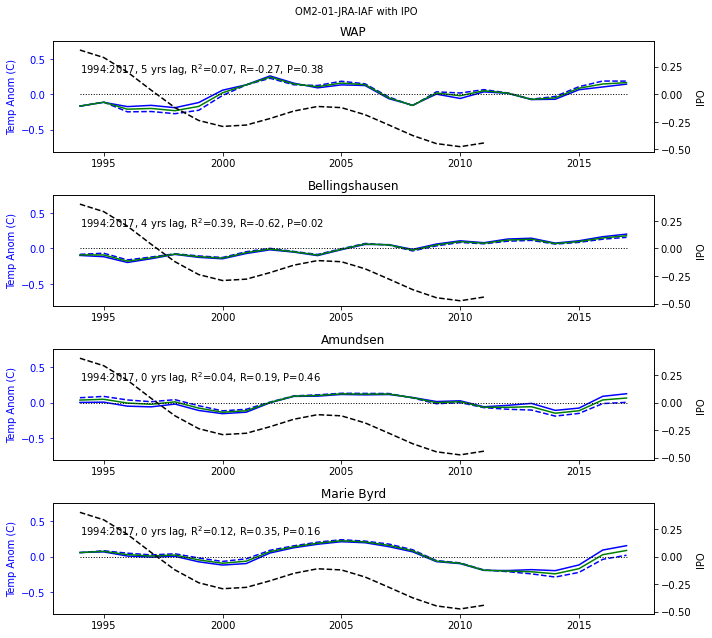

In [15]:
fig = plt.figure(figsize=(10, 9))

plt.suptitle('OM2-01-JRA-IAF with IPO', fontsize=10)

#anoms relative to multi-cycle mean (1958+myr:2017)
myr=36
maxlag=5

ts_t=wap_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(411)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)

ts_t=bs_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(412)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellingshausen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)


#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)


ts_t=as_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(413)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)


#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)


ts_t=mb_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(414)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Marie Byrd')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],ERSST_ipo_ann[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('IPO')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)


#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(ERSST_ipo_ann[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
l=lagcorr(a[:-6],b[:-6],maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)

plt.tight_layout()

In [16]:
#calc for correlations with hadsst nino34  (first and last 2 years are nans)
#anoms relative to multi-cycle mean (1958+myr:2017)
#correlations from 1958+myr:2017
myr=10
maxlag=5

#no lag
ts_t=as_t
#ensemble mean
ts_t=np.mean(ts_t[myr:,:],axis=1)
print(ts_t.shape)
#cycle mean
l_t=np.mean(ts_t)

a=ts_t-l_t
b=np.squeeze(hadsst_n34_ann_5yr[myr:,0])
print(a.shape,b.shape,b)
#lagged correlation
if myr ==0: 
    c= sp.stats.linregress(a[2:-2],b[2:-2])
else:
    c= sp.stats.linregress(a[:-2],b[:-2])
print('no lag',c)

#lagged correlation
if myr ==0: 
    l=lagcorr(a[2:-2],b[2:-2],maxlag)
else:
    l=lagcorr(a[:-2],b[:-2],maxlag)

print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
print("lagged lmax, rcor, pval",lmax[0],l[lmax[0],0],l[lmax[0],1])

#calc lagged linear regression
#rcor, pvalues - same as laggcorr
a=ts_t[lmax[0]:]-l_t
print(a.shape)
b=np.squeeze(hadsst_n34_ann_5yr[myr:-lmax[0]])
print(a.shape,b.shape)
if myr ==0: 
    c= sp.stats.linregress(a[2:-2],b[2:-2])
else:
    c= sp.stats.linregress(a[:-2],b[:-2])

corstr="lin regress: R$^2$=%.2f,R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
print(corstr)

#myr=30 (1978-2017) [lag=2, rcor=.43] [lag=13, rcor=.76]
#myr=20 (1978-2017) [lag=3, rcor=.1] [lag=13, rcor=.744]
#myr=10 (1968-2017) [lag=2, rcor=.49] [lag=13, rcor=.58]

(50,)
(50,) (50,) [ 0.04905556 -0.21627778 -0.03827778 -0.07277778 -0.39611111 -0.55094444
 -0.41577778 -0.42661111 -0.38777778 -0.15027778  0.07972222  0.10188889
  0.15405556  0.31705556  0.15588889 -0.03927778 -0.01261111  0.08588889
 -0.21127778 -0.26561111 -0.07627778  0.02755556 -0.06494444  0.17288889
  0.42055556  0.41988889  0.24338889  0.28505556  0.27838889  0.00105556
 -0.21127778 -0.20727778 -0.31361111 -0.32561111 -0.03994444  0.17655556
  0.23955556  0.08622222 -0.13427778 -0.17627778 -0.23644444 -0.40394444
 -0.35877778 -0.24927778 -0.23777778  0.05488889  0.36472222  0.35155556
         nan         nan]
no lag LinregressResult(slope=0.22355804242546035, intercept=-0.041779472877582366, rvalue=0.3437804350050478, pvalue=0.016737663027035492, stderr=0.0900365757316082, intercept_stderr=0.034715525556511403)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[0.34378044 0.01673766]
 [0.36376131 0.01195627]
 [0.37629518 0.00995399]
 [0.35920421 0.01538036]



#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


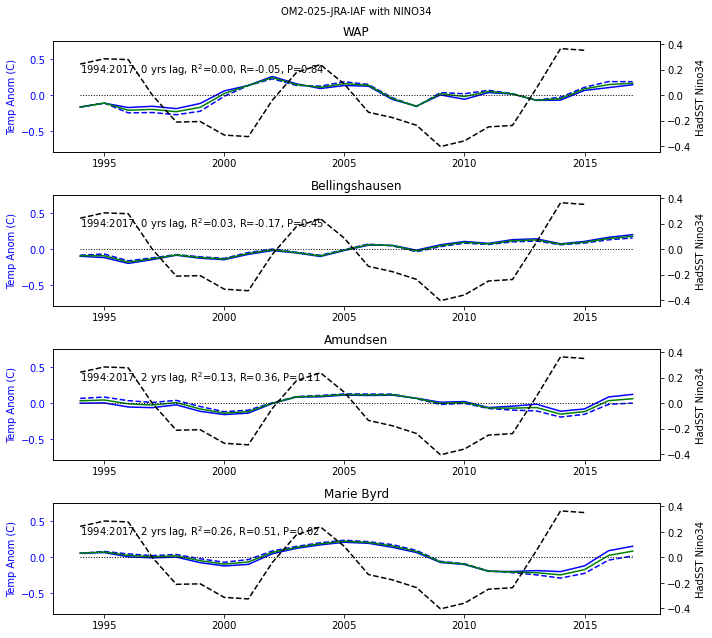

In [17]:
fig = plt.figure(figsize=(10, 9))

plt.suptitle('OM2-025-JRA-IAF with NINO34', fontsize=10)

#anoms relative to multi-cycle mean (1958+myr:2017)
myr=36
maxlag=5

ts_t=wap_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(411)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('WAP')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],hadsst_n34_ann_5yr[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('HadSST Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(hadsst_n34_ann_5yr[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
if myr ==0: 
    l=lagcorr(a[2:-2],b[2:-2],maxlag)
else:
    l=lagcorr(a[:-2],b[:-2],maxlag)
#print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)


ts_t=bs_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(412)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Bellingshausen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],hadsst_n34_ann_5yr[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('HadSST Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(hadsst_n34_ann_5yr[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
if myr ==0: 
    l=lagcorr(a[2:-2],b[2:-2],maxlag)
else:
    l=lagcorr(a[:-2],b[:-2],maxlag)
#print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)


ts_t=as_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(413)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],hadsst_n34_ann_5yr[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('HadSST Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(hadsst_n34_ann_5yr[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
if myr ==0: 
    l=lagcorr(a[2:-2],b[2:-2],maxlag)
else:
    l=lagcorr(a[:-2],b[:-2],maxlag)
#print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)


ts_t=mb_t[myr:,:]
l_t=np.mean(ts_t,axis=0)

ax1=plt.subplot(414)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,0]-l_t[0],linestyle='-',color='b',label='Cycle 2',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t[0:,1]-l_t[1],linestyle='--',color='b',label='Cycle 3',linewidth=1.5)
ax1.plot(yrs[myr:],np.mean(ts_t,axis=1)-np.mean(l_t),linestyle='-',color='g',label='Cycle Mean',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((yrs[myr:].shape[0],1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.75,.75))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Marie Byrd')
#ax1.set_xlabel('Years')
#ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(yrs[myr:],hadsst_n34_ann_5yr[myr:],linestyle='--',color='k',label='5yr LP Nino34',linewidth=1.5)
ax2.set_ylabel('HadSST Nino34')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

#calc lagged correlations with IPO (last 6 years are nan)
a=np.mean(ts_t,axis=1)-np.mean(np.mean(ts_t,axis=1))
b=np.squeeze(hadsst_n34_ann_5yr[myr:,0])
#print(a.shape,b.shape,b)
#lagged correlation
if myr ==0: 
    l=lagcorr(a[2:-2],b[2:-2],maxlag)
else:
    l=lagcorr(a[:-2],b[:-2],maxlag)
#print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.3,corstr)

plt.tight_layout()

In [19]:
3/12

0.25

In [18]:
as_mr = np.genfromtxt ('/g/data/v45/pas561/jnb/ensoant/data/melt_rate_amundsen.csv', delimiter=",")
print(as_mr.shape,as_mr[:,0])

print(yrs[36],yrs[36:].shape)
#print(np.mean(as_mr[1:,1],axis=0))
#print(as_mr.shape,as_mr[1::4,0])
#print(as_mr.itemsize)
as_mr_yr=as_mr[1:,:].reshape(25,4,3)
print(as_mr_yr.shape)
as_mr_yr=np.mean(as_mr_yr,axis=1)
print(as_mr_yr.shape,as_mr_yr[:,0])

as_mr_yr[:,0]=np.arange(1994,2019,1)
print(as_mr_yr.shape,as_mr_yr[:,0])

(101, 3) [    nan 1994.16 1994.41 1994.66 1994.91 1995.16 1995.41 1995.66 1995.91
 1996.16 1996.41 1996.66 1996.91 1997.16 1997.41 1997.66 1997.91 1998.16
 1998.41 1998.66 1998.91 1999.16 1999.41 1999.66 1999.91 2000.16 2000.41
 2000.66 2000.91 2001.16 2001.41 2001.66 2001.91 2002.16 2002.41 2002.66
 2002.91 2003.16 2003.41 2003.66 2003.91 2004.16 2004.41 2004.66 2004.91
 2005.16 2005.41 2005.66 2005.91 2006.16 2006.41 2006.66 2006.91 2007.16
 2007.41 2007.66 2007.91 2008.16 2008.41 2008.66 2008.91 2009.16 2009.41
 2009.66 2009.91 2010.16 2010.41 2010.66 2010.91 2011.16 2011.41 2011.66
 2011.91 2012.16 2012.41 2012.66 2012.91 2013.16 2013.41 2013.66 2013.91
 2014.16 2014.41 2014.66 2014.91 2015.16 2015.41 2015.66 2015.91 2016.16
 2016.41 2016.66 2016.91 2017.16 2017.41 2017.66 2017.91 2018.16 2018.41
 2018.66 2018.91]
1994 (24,)
(25, 4, 3)
(25, 3) [1994.535 1995.535 1996.535 1997.535 1998.535 1999.535 2000.535 2001.535
 2002.535 2003.535 2004.535 2005.535 2006.535 2007.535 2008.535 200

In [68]:
print(yrs)
yrs2=np.arange(1960,2020,1)
print(yrs2,yrs2.shape,yrs.shape)
as_mr_yr[:,0]


[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971
 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985
 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017]
[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019] (60,) (60,)


array([1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001., 2002.,
       2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010., 2011.,
       2012., 2013., 2014., 2015., 2016., 2017., 2018.])

In [75]:
#calc for correlations with basal melt
#anoms relative to multi-cycle mean (1958+myr:2017)
#correlations from 1958+myr:2017
myr=36
maxlag=5

#ensemble mean
ts_t=np.mean(as_t[myr:,:],axis=1)
print(ts_t.shape)
#cycle mean
l_t=np.mean(ts_t)

b=ts_t-l_t
#a= anom of melt rate
a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
print(a.shape,b.shape,b)
c= sp.stats.linregress(a,b)
print('no lag',c)

#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
print("lagged lmax, rcor, pval",lmax[0],l[lmax[0],0],l[lmax[0],1])

c= sp.stats.linregress(a[2:],b[:-2])
print('lagged no lag start 1960',c)

(24,)
(24,) (24,) [ 0.03468368  0.0460677  -0.00728858 -0.02456727  0.00951915 -0.0784616
 -0.13707965 -0.11576795  0.00177547  0.09010582  0.09961105  0.1223161
  0.11866048  0.12029474  0.06800544 -0.00133418  0.01203288 -0.06588592
 -0.06723362 -0.05900704 -0.15096413 -0.11580434  0.03664287  0.06367889]
no lag LinregressResult(slope=0.034229394103891864, intercept=-5.4487610495425384e-14, rvalue=0.20986698876904672, pvalue=0.32498403725006186, stderr=0.033998727065553666, intercept_stderr=0.01716265961562678)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[2.09866989e-01 3.24984037e-01]
 [6.13326990e-01 1.85717874e-03]
 [8.01059006e-01 7.48868656e-06]
 [7.17733900e-01 2.49130824e-04]
 [5.30842102e-01 1.60318907e-02]
 [2.83504899e-01 2.39514464e-01]]
lagged lmax, rcor, pval 2 0.8010590061033471 7.488686556805645e-06
lagged no lag start 1960 LinregressResult(slope=0.13179563370938283, intercept=-0.00895665526519332, rvalue=0.801059006103347, pvalue=7.4886865568056

In [89]:
#try using 1992-2016 temp correlated with mr 1994-2018
print(yrs[myr-2:-1],yrs[myr-2:-1].shape)

ts_t2=np.mean(as_t[myr-2:-1,:],axis=1)
l_t2=np.mean(ts_t2) #shelf,wap,bs,as,mb
b=ts_t2-l_t2

#a= anom of melt rate
print(as_mr_yr[:,0],as_mr_yr[:,0].shape)
a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)

print(a.shape,b.shape)
c= sp.stats.linregress(a,b)
print('lagged no lag v2',c)

[1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016] (25,)
[1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005.
 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017.
 2018.] (25,)
(25,) (25,)
lagged no lag v2 LinregressResult(slope=0.12500106630889268, intercept=-1.3682388896426546e-14, rvalue=0.761476597452947, pvalue=9.818557554805756e-06, stderr=0.02218692809352374, intercept_stderr=0.011111374104521123)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


(24,)
(25,) [1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016] (25,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]


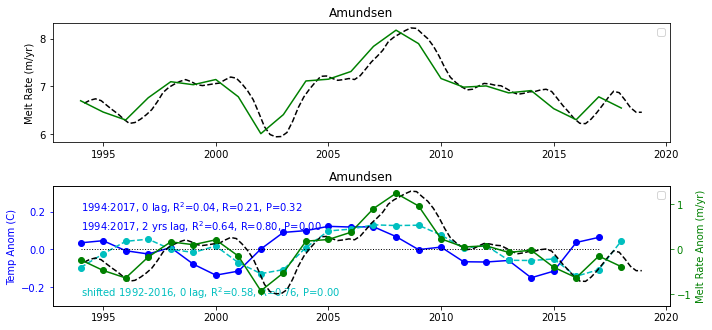

In [95]:
#load obs basal melt data for amundsen from Susheel Adusumilli (sioglaciology)
#time, melt,melt uncertainty
myr=36
maxlag=5

fig = plt.figure(figsize=(10, 9))

#take multi-cycle mean temp
ts_t=np.mean(as_t[myr:,:],axis=1)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape)

#yrs2=np.arange(1960,2020,1)

ts_t2=np.mean(as_t[myr-2:-1,:],axis=1)
l_t2=np.mean(ts_t2) #shelf,wap,bs,as,mb
print(ts_t2.shape,yrs[myr-2:-1],yrs[myr-2:-1].shape)

ax1=plt.subplot(411)
ax1.plot(as_mr[1:,0],as_mr[1:,1],linestyle='--',color='k',linewidth=1.5)
ax1.plot(as_mr_yr[:,0],as_mr_yr[:,1],linestyle='-',color='g',linewidth=1.5)
#ax1.plot(yrs[36:],np.zeros((24,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((-.75,.75))
ax1.set_ylabel('Melt Rate (m/yr)',color='k')
#ax1.tick_params('y', colors='b')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)


ax1=plt.subplot(412)
#ax1.plot(yrs,wap_ssh_pert-wap_ssh_cntrl,linestyle='-',color='g',label='WAP',linewidth=1.5)
ax1.plot(yrs[myr:],ts_t-l_t,linestyle='-',color='b',marker='o',linewidth=1.5)
ax1.plot(as_mr_yr[:,0],ts_t2-l_t2,linestyle='--',color='c',marker='o',linewidth=1.5)
#ax1.plot(yrs2[myr:],ts_t-l_t,linestyle='-',color='r',marker='o',linewidth=1.5)
ax1.plot(yrs[myr:],np.zeros((60-myr,1)),linestyle=':',color='k',linewidth=1)
plt.ylim((-.3,.3))
ax1.set_ylabel('Temp Anom (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Amundsen')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax2=ax1.twinx()
ax2.plot(as_mr[1:,0],as_mr[1:,1]-np.mean(as_mr[1:,1],axis=0),linestyle='--',color='k',linewidth=1.5)
ax2.plot(as_mr_yr[:,0],as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0),linestyle='-',color='g',marker='o',linewidth=1.5)
ax2.set_ylabel('Melt Rate Anom (m/yr)',color='g')#ax2.plot(yrs,as_ssh_pert-as_ssh_cntrl,linestyle='--',color='y',label='SSH Amunds.',linewidth=1.5)
ax2.tick_params('y', colors='g')
#ax2.set_ylabel('SSH (m)')
#ax2.set_xlabel('Years')
#ax2.legend(fontsize=10)
align_yaxis_np(ax1,ax2)

b=ts_t-l_t
a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
ax1.text(1958+myr,0.1,corstr,color='b')
corstr="%.0f:2017, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,l[0,0]*l[0,0],l[0,0],l[0,1])
ax1.text(1958+myr,0.2,corstr,color='b')

b=ts_t2-l_t2
a=as_mr_yr[:,1]-np.mean(as_mr_yr[:,1],axis=0)
#print(a.shape,b.shape)
c= sp.stats.linregress(a,b)
#print(c)
corstr="shifted 1992-2016, 0 lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
ax1.text(1958+myr,-0.25,corstr,color='c')

plt.tight_layout()


In [33]:
#do a lagged linear regression scatter plot
myr=36
maxlag=5

#take multi-cycle mean temp
ts_t=np.mean(as_t[myr:,:],axis=1)
l_t=np.mean(ts_t) #shelf,wap,bs,as,mb
print(ts_t.shape,l_t.shape)

b=ts_t-l_t
a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
#lagged cor, a lags b
l=lagcorr(a,b,maxlag)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
corstr="%.0f:2017, %.0f yrs lag, R$^2$=%.2f, R=%.2f, P=%.2f" %(1958+myr,lmax[0],l[lmax[0],0]*l[lmax[0],0],l[lmax[0],0],l[lmax[0],1])
print(corstr)

#calc lagged linear regression
#rcor, pvalues - same as laggcorr
print(a.shape,b.shape)
c= sp.stats.linregress(a[2:],b[:-2])
print(c)
corstr="regressed R$^2$=%.2f, R=%.2f, P=%.2f" %(c.rvalue*c.rvalue,c.rvalue,c.pvalue)
print(corstr)


(24,) ()

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
1994:2017, 2 yrs lag, R$^2$=0.64, R=0.80, P=0.00
(24,) (24,)
LinregressResult(slope=0.13179563370938283, intercept=-0.00895665526519332, rvalue=0.801059006103347, pvalue=7.488686556805675e-06, stderr=0.022021537116415996, intercept_stderr=0.011325018681828891)
regressed R$^2$=0.64, R=0.80, P=0.00


(24,)

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[ 1.00000000e+00  0.00000000e+00]
 [ 7.31829690e-01  7.22286812e-05]
 [ 3.22333321e-01  1.43465440e-01]
 [ 7.80743548e-02  7.36578629e-01]
 [-2.00607111e-01  3.96412332e-01]
 [-4.82646302e-01  3.63475157e-02]]
Temp Anom autocorrelation lagged lmax, rcor, pval 0 1.0 0.0

#<lagcorr>: Computing lagged-correlations at lags: [0 1 2 3 4 5]
[[ 1.00000000e+00  0.00000000e+00]
 [ 7.25224004e-01  9.02883819e-05]
 [ 3.04298171e-01  1.68547987e-01]
 [ 4.25919904e-02  8.54553198e-01]
 [-1.56023241e-01  5.11264217e-01]
 [-2.84637016e-01  2.37561854e-01]]
Melt Anom autocorrelation lagged lmax, rcor, pval 0 1.0 0.0


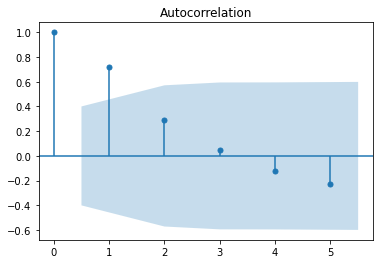

In [28]:
#test for autocorrelation
#calc for correlations with basal melt
#anoms relative to multi-cycle mean (1958+myr:2017)
#correlations from 1958+myr:2017
myr=36
maxlag=5

#ensemble mean
ts_t=np.mean(as_t[myr:,:],axis=1)
print(ts_t.shape)
#cycle mean
l_t=np.mean(ts_t)

b=ts_t-l_t
#a= anom of melt rate
a=as_mr_yr[:-1,1]-np.mean(as_mr_yr[:-1,1],axis=0)
#print(a.shape,b.shape,b)
#c= sp.stats.linregress(a,b)
#print('no lag',c)

#lagged cor, a lags b
l=lagcorr(b,b,maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
print("Temp Anom autocorrelation lagged lmax, rcor, pval",lmax[0],l[lmax[0],0],l[lmax[0],1])

#lagged cor, a lags b
l=lagcorr(a,a,maxlag)
print(l)
lmax = np.where(l[:,0] == np.amax(l[:,0]))[0]
print("Melt Anom autocorrelation lagged lmax, rcor, pval",lmax[0],l[lmax[0],0],l[lmax[0],1])

sm.graphics.tsa.plot_acf(a, lags=5)
plt.show()